In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_path_1= 'https://drive.google.com/file/d/1gRNNfzKBtJc6jeEPRQpT_BhA-L0XX5lv/view?usp=share_link'
file_id = '1gRNNfzKBtJc6jeEPRQpT_BhA-L0XX5lv'
url= 'https://drive.google.com/uc?id=1gRNNfzKBtJc6jeEPRQpT_BhA-L0XX5lv'
data_1 = pd.read_csv(url, header=0, low_memory=False)

In [ ]:
data_1

,Unnamed: 0,gvkey,date,tickers,ret_exc,seas_6_10an,seas_6_10na,cop_at,noa_gr1a,o_score,ival_me,resff3_12_1
0,49989,126554,2013-01-31,A,0.093774,-0.026433,0.022186,0.246592,0.216726,-4.095107,0.635418,-0.130842
1,49990,126554,2013-02-28,A,-0.073748,-0.009901,0.022556,0.216401,0.246218,-4.090522,0.808706,-0.002125
2,49991,126554,2013-03-28,A,0.014665,0.010045,0.020349,0.216401,0.246218,-4.090522,0.798825,-0.131062
3,49992,126554,2013-04-30,A,-0.012665,0.051800,0.012816,0.216401,0.246218,-4.090522,0.809041,-0.205422
4,49993,126554,2013-05-31,A,0.096754,0.017604,0.017852,0.226509,0.246621,-4.055302,0.683657,-0.305863
...,...,...,...,...,...,...,...,...,...,...,...,...
61565,6988,13721,2023-08-31,ZTS,0.008329,0.012533,0.021999,0.292351,0.062410,-2.735078,0.227159,0.011460
61566,6989,13721,2023-09-29,ZTS,-0.091034,-0.002088,0.022292,0.292351,0.062410,-2.735078,0.248742,0.061266
61567,6990,13721,2023-10-31,ZTS,-0.100157,0.094595,0.012869,0.279584,0.071678,-2.817677,0.306535,0.102932
61568,6991,13721,2023-11-30,ZTS,0.120863,0.018468,0.020858,0.279584,0.071678,-2.817677,0.273120,-0.000346


In [ ]:
data=data_1.copy()

In [ ]:
data['date'] = pd.to_datetime(data['date'])
# Extract only the month (as an integer)
data['date'] = data['date'].dt.strftime('%Y-%m')
data['date'] = pd.to_datetime(data['date'])
stock_returns = data[['date', 'tickers', 'ret_exc']]
stock_returns = stock_returns.drop_duplicates(subset=['date', 'tickers'])
data.set_index(['tickers', 'date'], inplace=True)


In [ ]:
from scipy.stats.mstats import winsorize

# Define columns to process
columns_to_check = ['ret_exc', 'seas_6_10an', 'seas_6_10na', 'cop_at', 'noa_gr1a', 'o_score', 'ival_me', 'resff3_12_1']

# Ensure numeric conversion and apply winsorization column-wise
for col in columns_to_check:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric
    data[col] = winsorize(data[col].values, limits=[0.02, 0.02])  # Winsorize

# Interpolate missing values
data_filtered = data.interpolate(method='linear')

# Drop rows where any required column still has NaN
data_filtered = data_filtered.dropna(subset=columns_to_check)

# Display result
print(data_filtered.head())

                    Unnamed: 0   gvkey   ret_exc  seas_6_10an  seas_6_10na  \
tickers date                                                                 
A       2013-01-01       49989  126554  0.093774    -0.026433     0.022186   
        2013-02-01       49990  126554 -0.073748    -0.009901     0.022556   
        2013-03-01       49991  126554  0.014665     0.010045     0.020349   
        2013-04-01       49992  126554 -0.012665     0.051800     0.012816   
        2013-05-01       49993  126554  0.096754     0.017604     0.017852   

                      cop_at  noa_gr1a   o_score   ival_me  resff3_12_1  
tickers date                                                             
A       2013-01-01  0.246592  0.216726 -4.095107  0.635418    -0.130842  
        2013-02-01  0.216401  0.246218 -4.090522  0.808706    -0.002125  
        2013-03-01  0.216401  0.246218 -4.090522  0.798825    -0.131062  
        2013-04-01  0.216401  0.246218 -4.090522  0.809041    -0.205422  
        2

In [ ]:
tickers=data_filtered.index.levels[0]

In [ ]:
tickers

Index(['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM',
       ...
       'WST', 'WTW', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', name='tickers', length=473)

In [ ]:
import tensorflow as tf

In [ ]:
data_filtered

Unnamed: 0   gvkey   ret_exc  seas_6_10an  seas_6_10na  \
tickers date                                                                 
A       2013-01-01       49989  126554  0.093774    -0.026433     0.022186   
        2013-02-01       49990  126554 -0.073748    -0.009901     0.022556   
        2013-03-01       49991  126554  0.014665     0.010045     0.020349   
        2013-04-01       49992  126554 -0.012665     0.051800     0.012816   
        2013-05-01       49993  126554  0.096754     0.017604     0.017852   
...                        ...     ...       ...          ...          ...   
ZTS     2023-08-01        6988   13721  0.008329     0.012533     0.021999   
        2023-09-01        6989   13721 -0.091034    -0.002088     0.022292   
        2023-10-01        6990   13721 -0.100157     0.094595     0.012869   
        2023-11-01        6991   13721  0.120863     0.018468     0.020858   
        2023-12-01        6992   13721  0.112902    -0.015722     0.021454   

                      cop_at  noa_gr1a   o_score   ival_me  resff3_12_1  
tickers date                                                             
A       2013-01-01  0.246592  0.216726 -4.095107  0.635418    -0.130842  
        2013-02-01  0.216401  0.246218 -4.090522  0.808706    -0.002125  
        2013-03-01  0.216401  0.246218 -4.090522  0.798825    -0.131062  
        2013-04-01  0.216401  0.246218 -4.090522  0.809041    -0.205422  
        2013-05-01  0.226509  0.246621 -4.055302  0.683657    -0.305863  
...                      ...       ...       ...       ...          ...  
ZTS     2023-08-01  0.292351  0.062410 -2.735078  0.227159     0.011460  
        2023-09-01  0.292351  0.062410 -2.735078  0.248742     0.061266  
        2023-10-01  0.279584  0.071678 -2.817677  0.306535     0.102932  
        2023-11-01  0.279584  0.071678 -2.817677  0.273120    -0.000346  
        2023-12-01  0.279584  0.071678 -2.817677  0.244475    -0.001821  

[61570 rows x 10 columns]

In [ ]:
import pandas as pd
import requests
import zipfile
import io

# URL of the ZIP file
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"

# Step 1: Download the ZIP file
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))  # Convert to in-memory ZIP

# Step 2: Extract and list files
zip_file_contents = zip_file.namelist()
print("Files inside ZIP:", zip_file_contents)  # Check file names inside ZIP

# Step 3: Read the first CSV (or choose the correct one if multiple)
csv_filename = zip_file_contents[0]  # First file in ZIP (check manually if needed)
with zip_file.open(csv_filename) as file:
    df = pd.read_csv(file, skiprows=3)  # Skip metadata rows if necessary

# Step 4: Display the first few rows
print(df.head())


Files inside ZIP: ['F-F_Research_Data_5_Factors_2x3.csv']
  Unnamed: 0    Mkt-RF       SMB       HML       RMW       CMA        RF
0     196307     -0.39     -0.41     -0.97      0.68     -1.18      0.27
1     196308      5.07     -0.80      1.80      0.36     -0.35      0.25
2     196309     -1.57     -0.52      0.13     -0.71      0.29      0.27
3     196310      2.53     -1.39     -0.10      2.80     -2.01      0.29
4     196311     -0.85     -0.88      1.75     -0.51      2.24      0.27


In [ ]:
ff_5_monthly=df[:738]

In [ ]:
ff_5_monthly=ff_5_monthly.rename(columns={'Unnamed: 0': 'date'})

In [ ]:
ff_5_monthly['date'] = pd.to_datetime(ff_5_monthly['date'], format='%Y%m')

In [ ]:
ff_5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = ff_5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].astype(float)

In [ ]:
ff_5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]=ff_5_monthly[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]/100
ff_5_monthly['RF'] = ff_5_monthly['RF']/10

In [ ]:
ff_5_monthly.set_index('date', inplace=True)

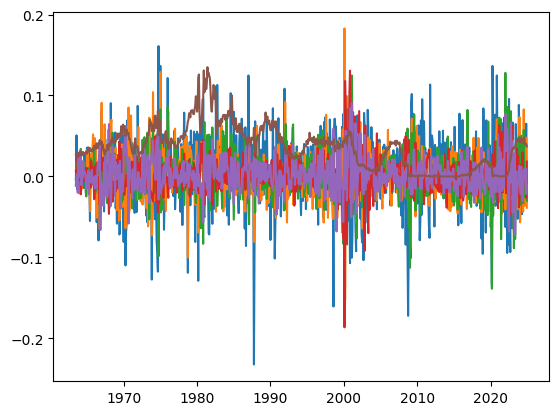

In [ ]:
plt.plot(ff_5_monthly)
plt.show()

In [ ]:

## Regress the excess return of the portfolio first on the market beta and then on
## the Fama&French 5 factors plus momentum

# Upload the Fama&French factors data
#FF = pd.read_csv("/Users/lucadonadini/Desktop/Magistrale/Secondo anno/Second semester/Advanced Investments/Research project/FF6.csv", delimiter=',')
#FF.rename(columns={'dateff': 'date'}, inplace=True)
#FF['date'] = pd.to_datetime(FF['date'])
#FF['date'] = FF['date'].dt.strftime('%Y-%m')
#FF['date'] = pd.to_datetime(FF['date'])

# Merge the two datasets
merged_data = pd.merge(data_filtered, ff_5_monthly, on='date', how='inner')



In [ ]:
def min_max_scale_df(df): #scale for pca
    """
    Scale every numeric column in the DataFrame to the range [0, 1].
    Non-numeric columns are left unchanged.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame.

    Returns:
    --------
    pd.DataFrame
        A new DataFrame with numeric columns scaled to [0, 1].
    """
    scaled_df = df.copy()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            col_min = df[col].min()
            col_max = df[col].max()
            if col_max - col_min == 0:
                scaled_df[col] = 0.0
            else:
                scaled_df[col] = (df[col] - col_min) / (col_max - col_min)
    return scaled_df

In [ ]:
merged_data[['seas_6_10an',	'seas_6_10na'	,'cop_at',	'noa_gr1a'	,'o_score'	,'ival_me',	'resff3_12_1'	,'Mkt-RF'	,'SMB',	'HML',	'RMW',	'CMA',	'RF']]=min_max_scale_df(merged_data[['seas_6_10an',	'seas_6_10na'	,'cop_at',	'noa_gr1a'	,'o_score'	,'ival_me',	'resff3_12_1'	,'Mkt-RF'	,'SMB',	'HML',	'RMW',	'CMA',	'RF']])

[]

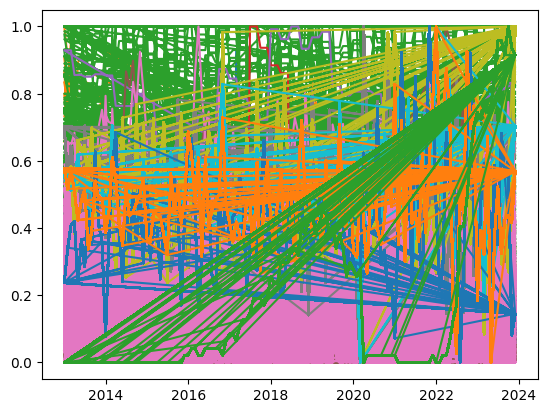

In [ ]:
plt.plot(merged_data[['seas_6_10an',	'seas_6_10na'	,'cop_at',	'noa_gr1a'	,'o_score'	,'ival_me',	'resff3_12_1'	,'Mkt-RF'	,'SMB',	'HML',	'RMW',	'CMA',	'RF']])
plt.plot()

In [ ]:
merged_data

,Unnamed: 0,gvkey,ret_exc,seas_6_10an,seas_6_10na,cop_at,noa_gr1a,o_score,ival_me,resff3_12_1,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,,,,,,,,,,,
2013-01-01,49989,126554,0.093774,0.058649,0.265983,0.470250,0.035957,0.126203,0.035997,0.189101,0.701183,0.560051,0.556222,0.237148,0.576305,0.000000
2013-02-01,49990,126554,-0.073748,0.083955,0.269342,0.409851,0.038902,0.126392,0.046699,0.245363,0.542899,0.513166,0.524363,0.341625,0.516734,0.000000
2013-03-01,49991,126554,0.014665,0.114489,0.249337,0.409851,0.038902,0.126392,0.046089,0.189005,0.644231,0.583815,0.513118,0.407960,0.574297,0.000000
2013-04-01,49992,126554,-0.012665,0.178407,0.181085,0.409851,0.038902,0.126392,0.046720,0.156503,0.552515,0.384714,0.537106,0.419569,0.507363,0.000000
2013-05-01,49993,126554,0.096754,0.126060,0.226710,0.430073,0.038942,0.127840,0.038976,0.112600,0.598743,0.661529,0.618816,0.233831,0.423695,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,6988,13721,0.008329,0.118298,0.264288,0.561794,0.020548,0.182147,0.010783,0.251301,0.406805,0.292871,0.479760,0.680763,0.323293,0.957447
2023-09-01,6989,13721,-0.091034,0.095915,0.266944,0.561794,0.020548,0.182147,0.012116,0.273071,0.301405,0.414258,0.574588,0.550580,0.425703,0.914894
2023-10-01,6990,13721,-0.100157,0.243917,0.181564,0.536252,0.021473,0.178749,0.015686,0.291283,0.377589,0.269107,0.527361,0.601990,0.437082,1.000000


In [ ]:
import tensorflow as tf
import numpy as np
from scipy.stats import gmean

def positional_encoding(length, depth):
    """
    Generate a positional encoding with exactly 'depth' features.
    If necessary, pad the result so that its last dimension is exactly 'depth'.
    """
    # Cast depth for computations.
    depth_float = tf.cast(depth, tf.float32)
    depth_int = tf.cast(depth, tf.int32)

    # Compute half depth (for sin and cos parts).
    half_depth = depth_int // 2

    # positions: shape (length, 1)
    positions = tf.range(length, dtype=tf.float32)[:, tf.newaxis]
    # depths_range: shape (1, half_depth)
    depths_range = tf.range(half_depth, dtype=tf.float32)[tf.newaxis, :]

    # Scale depths_range by (depth / 2) so that division is done in float.
    denom = depth_float / 2.0
    depths_scaled = depths_range / denom  # shape: (1, half_depth)

    # Compute the angle rates and angles.
    angle_rates = 1 / (10000 ** depths_scaled)  # shape: (1, half_depth)
    angle_rads = positions * angle_rates          # shape: (length, half_depth)

    # Concatenate sin and cos to get a tensor of shape (length, half_depth*2)
    pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)

    # Pad if the concatenated dimension is less than the desired depth.
    current_depth = tf.shape(pos_encoding)[-1]
    pad_size = depth_int - current_depth
    pos_encoding = tf.pad(pos_encoding, [[0, 0], [0, pad_size]])

    # Finally, slice to ensure the last dimension is exactly depth.
    pos_encoding = pos_encoding[:, :depth_int]

    return pos_encoding  # shape: (length, depth)

class CnnPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, length, d_model=None):
        """
        length: maximum sequence length.
        d_model: if provided, this fixed feature dimension is used;
                 otherwise, the layer infers the input's feature dimension.
        """
        super().__init__()
        self.length = length
        self.d_model = d_model  # if None, will use input's last dimension

    def call(self, x):
        batch_size = tf.shape(x)[0]
        seq_length = tf.shape(x)[1]
        # Determine number of features: use d_model if provided; otherwise, infer from x.
        if self.d_model is not None:
            num_features = self.d_model
        else:
            num_features = x.shape[-1] if x.shape[-1] is not None else tf.shape(x)[-1]

        # Generate positional encoding with exactly num_features features.
        pos_encoding = positional_encoding(seq_length, num_features)
        # pos_encoding shape: (seq_length, num_features)

        # Expand and tile to shape (batch_size, seq_length, num_features)
        pos_encoding = tf.expand_dims(pos_encoding, 0)
        pos_encoding = tf.tile(pos_encoding, [batch_size, 1, 1])

        return x + pos_encoding

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x, key=context, value=context, return_attention_scores=True)
        self.last_attn_scores = attn_scores  # Cache scores for later (if needed)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x, use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = CausalSelfAttention(
            num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff, dropout_rate)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, length, num_layers, d_model, num_heads, dff, dropout_rate=0.25):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        # Here, we force the encoder to operate in a space of dimension d_model.
        self.CnnPositionalEncoding = CnnPositionalEncoding(length=length, d_model=d_model)
        self.enc_layers = [
            EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.CnnPositionalEncoding(x)  # Add positional encoding.
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x  # Output shape: (batch_size, seq_length, d_model)

class Lstm(tf.keras.layers.Layer):
    def __init__(self, d_data, target_dim):
        """
        d_data: number of features for the LSTM input.
        target_dim: final output dimension (e.g. 473 if that's your target dimension).
        """
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.LSTM(d_data, activation='tanh', recurrent_activation='tanh',
                                 use_bias=True, return_sequences=True, dropout=0.1),
            tf.keras.layers.LSTM(target_dim, activation='tanh', recurrent_activation='tanh',
                                 use_bias=True, return_sequences=True, dropout=0.1),
            tf.keras.layers.Dense(target_dim, activation='tanh')
        ])

    def call(self, x):
        return self.seq(x)


In [ ]:
class LSTM_Encoder(tf.keras.Model):
  def __init__(self, *,length,d_data,target_dim,
               num_layers, d_model, num_heads, dff, dropout_rate=0.1):
      super().__init__()
      self.lstm= Lstm(d_data=d_data,target_dim=target_dim)
      #self.cnn = CNN(length=length,d_data=d_data,Filters=Filters,kernel=kernel)
      self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           length=length,
                           dropout_rate=dropout_rate)
      self.dropout = tf.keras.layers.Dropout(dropout_rate) #d_model: 20*(14+1)*8 cumulative residuals are also a feature
      #self.final_layer_1 = tf.keras.layers.Dense(40,activation='relu')
      #self.final_layer_2 = tf.keras.layers.Dense(d_model,activation='tanh')
      #self.final_layer_3 = tf.keras.layers.Dense(d_model,activation='tanh')
      #self.final_layer_4 = tf.keras.layers.Dense(d_model/14*5*2,activation='tanh')
      self.output_layer =tf.keras.layers.Dense(target_dim,activation='tanh')
      #self.softmax_layer=tf.keras.layers.Softmax() #default is last axis, axis need to be checked
  def call(self, inputs):
      x=inputs
      x=self.lstm(x)
      #x=self.cnn(x) #How does the model sequentially!!!
      x=self.encoder(x)  # (batch_size, context_len, d_model)
      #x=self.final_layer_1(x)
      x=self.output_layer(x) #(x[:,-1,:])

      try:
          del x._keras_mask
      except AttributeError:
          pass
      return x#logits

In [ ]:
class GeometricSharpeRatioLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred):
        # Calculate portfolio return using predicted weights and actual returns
        portfolio_return = tf.reduce_sum(y_pred * y_true, axis=1)

        # Handling edge cases
        portfolio_return = tf.where(tf.math.is_nan(portfolio_return), tf.zeros_like(portfolio_return), portfolio_return)

        # Calculate geometric mean
        geometric_mean = tf.reduce_prod(1 + portfolio_return, axis=0) ** (1.0 / tf.cast(tf.shape(portfolio_return)[0], tf.float32))

        # Handling edge cases
        geometric_mean = tf.where(tf.math.is_nan(geometric_mean), tf.ones_like(geometric_mean), geometric_mean)
        portfolio_volatility=(tf.math.reduce_std(portfolio_return, axis=0)+ 1e-10)

        # Calculate Sharpe ratio
        #sharpe_ratio = geometric_mean / portfolio_volatility
        sharpe_ratio = portfolio_return / portfolio_volatility

        # Handling edge cases
        sharpe_ratio = tf.where(tf.math.is_nan(sharpe_ratio), tf.ones_like(sharpe_ratio), sharpe_ratio)

        # Calculate negative geometric mean of daily Sharpe ratios
        return -sharpe_ratio

In [ ]:
import numpy as np
import pandas as pd

def create_dataset_train(data, window_size, stride, batch_size, num_features):
    x, y, index = [], [], []
    for i in range(0, data.shape[0] - window_size, stride):
        x.append(data.iloc[i : i + window_size].values)
        y.append(data.iloc[i + window_size].values)
        index.append(data.index[i + window_size])

    x, y, index = np.array(x), np.array(y), np.array(index)

    # Ensure batch size is a multiple of batch_size
    total_size = x.shape[0]
    new_size = batch_size * (total_size // batch_size)
    start_size = total_size - new_size
    x = x[start_size:].reshape(new_size, window_size, num_features)
    y = y[start_size:].reshape(new_size, num_features)
    index = index[start_size:].reshape(new_size, 1)
    index_flat = index.ravel()
    index=pd.to_datetime(index_flat, format='%Y-%m-%d')

    return x, y, index

In [ ]:
def create_features_test(data, window_size, stride, batch_size, num_features):
    x, y, index = [], [], []
    for i in range(0, data.shape[0] - window_size, stride):
        x.append(data.iloc[i+1 : i + window_size+1].values)
        index.append(data.index[i + window_size])

    x, y, index = np.array(x), np.array(y), np.array(index)

    # Ensure batch size is a multiple of batch_size
    total_size = x.shape[0]
    new_size = batch_size * (total_size // batch_size)
    start_size = total_size - new_size
    x = x[start_size:].reshape(new_size, window_size, num_features)
    #y = y[start_size:].reshape(new_size, num_features)
    index = index[start_size:].reshape(new_size, 1)
    index_flat = index.ravel()
    index=pd.to_datetime(index_flat, format='%Y-%m-%d')


    return x,index

In [ ]:
def create_dataset_train(data, window_size, stride, batch_size, num_features):
    x, y, index = [], [], []
    for i in range(0, data.shape[0] - window_size, stride):
        x.append(data.iloc[i : i + window_size].values)
        y.append(data.iloc[i + window_size].values)
        index.append(data.index[i + window_size])

    x, y, index = np.array(x), np.array(y), np.array(index)

    # Ensure batch size is a multiple of batch_size
    total_size = x.shape[0]
    new_size = batch_size * (total_size // batch_size)
    start_size = total_size - new_size
    x = x[start_size:].reshape(new_size, window_size, num_features)
    y = y[start_size:].reshape(new_size, num_features)
    index = index[start_size:].reshape(new_size, 1)
    index_flat = index.ravel()
    index=pd.to_datetime(index_flat, format='%Y-%m-%d')

    return x, y, index

In [ ]:
def create_dataset_train_modified(data, window_size, stride, batch_size, num_features):
    x,index = [], []
    for i in range(0, data.shape[0] - window_size, stride):
        x.append(data.iloc[i : i + window_size].values)
        index.append(data.index[i + window_size])

    x, index = np.array(x), np.array(index)

    # Ensure batch size is a multiple of batch_size
    total_size = x.shape[0]
    new_size = batch_size * (total_size // batch_size)
    start_size = total_size - new_size
    x = x[start_size:].reshape(new_size, window_size, num_features)
    index = index[start_size:].reshape(new_size, 1)
    index_flat = index.ravel()
    index=pd.to_datetime(index_flat, format='%Y-%m-%d')

    return x,index

In [ ]:
def create_features_test(data, window_size, stride, batch_size, num_features):
    x, y, index = [], [], []
    for i in range(0, data.shape[0] - window_size, stride):
        x.append(data.iloc[i+1 : i + window_size+1].values)
        index.append(data.index[i + window_size])

    x, y, index = np.array(x), np.array(y), np.array(index)

    # Ensure batch size is a multiple of batch_size
    total_size = x.shape[0]
    new_size = batch_size * (total_size // batch_size)
    start_size = total_size - new_size
    x = x[start_size:].reshape(new_size, window_size, num_features)
    #y = y[start_size:].reshape(new_size, num_features)
    index = index[start_size:].reshape(new_size, 1)
    index_flat = index.ravel()
    index=pd.to_datetime(index_flat, format='%Y-%m-%d')

    return x,index

In [ ]:
train_ratio = 0.8

# Step 1: Filter out gvkeys with fewer than 100 observations
gvkey_counts = merged_data['gvkey'].value_counts()
valid_gvkeys = gvkey_counts[gvkey_counts >= 100].index  # Keep only gvkeys with 100+ rows
filtered_data = merged_data[merged_data['gvkey'].isin(valid_gvkeys)]  # Remove small gvkeys

# Step 2: Dictionary to store train-test sets separately for each gvkey
train_sets = {}
test_sets = {}

# Step 3: Loop through each gvkey and create separate train-test splits
for gvkey, group in filtered_data.groupby("gvkey"):
    group = group.sort_index()  # Ensure the data is sorted by date

    # Drop duplicate dates for this gvkey, keeping only the first occurrence
    group = group[~group.index.duplicated(keep='first')]

    # Compute split index
    split_idx = int(len(group) * train_ratio)

    # Train and test split
    train_sets[gvkey] = group.iloc[:split_idx].drop(columns=['gvkey'])  # First 80% for training
    test_sets[gvkey] = group.iloc[split_idx:].drop(columns=['gvkey'])   # Last 20% for testing

# Step 4: Example - Accessing train set for a specific gvkey
example_gvkey = list(train_sets.keys())[0]

# Step 5: Check if gvkeys with < 100 observations are removed
print("Unique gvkeys in train sets:", len(train_sets))
print("Unique gvkeys in test sets:", len(test_sets))
print(f"Train set for gvkey {example_gvkey}:\n", train_sets[example_gvkey].head())


Unique gvkeys in train sets: 442
Unique gvkeys in test sets: 442
Train set for gvkey 1075:
             Unnamed: 0   ret_exc  seas_6_10an  seas_6_10na    cop_at  \
date                                                                   
2013-01-01       20337  0.057746     0.072430     0.162647  0.274135   
2013-02-01       20338  0.047904     0.124604     0.125969  0.274135   
2013-03-01       20339  0.034818     0.118445     0.112540  0.274135   
2013-04-01       20340  0.061373     0.150524     0.090383  0.281932   
2013-05-01       20341 -0.072590     0.059500     0.115576  0.281932   

            noa_gr1a   o_score   ival_me  resff3_12_1    Mkt-RF       SMB  \
date                                                                        
2013-01-01  0.015007  0.135483  0.029579     0.167591  0.701183  0.560051   
2013-02-01  0.015007  0.135483  0.028061     0.242610  0.542899  0.513166   
2013-03-01  0.015007  0.135483  0.027007     0.294233  0.644231  0.583815   
2013-04-01  0.0146

In [ ]:
train_ratio = 0.8

# Step 1: Filter out gvkeys with fewer than 100 observations
gvkey_counts = merged_data['gvkey'].value_counts()
valid_gvkeys = gvkey_counts[gvkey_counts >= 100].index  # Keep only gvkeys with 100+ rows
filtered_data = merged_data[merged_data['gvkey'].isin(valid_gvkeys)]

# Optional: Sort the entire filtered dataset by its index (e.g., date)
filtered_data = filtered_data.sort_index()
filtered_data = filtered_data.drop(columns=['Unnamed: 0'])
# Step 2: Dictionary to store train-test sets separately for each gvkey
train_sets = {}
test_sets = {}

# Step 3: Loop through each gvkey and create separate train-test splits
for gvkey, group in filtered_data.groupby("gvkey"):
    # Ensure the group's index is sorted (e.g., by date)
    group = group.sort_index()

    # Drop duplicate dates for this gvkey, keeping only the first occurrence
    group = group[~group.index.duplicated(keep='first')]

    # Compute split index
    split_idx = int(len(group) * train_ratio)

    # Train and test split and then sort each split by the index
    train = group.iloc[:split_idx].drop(columns=['gvkey']).sort_index()
    test = group.iloc[split_idx:].drop(columns=['gvkey']).sort_index()

    train_sets[gvkey] = train
    test_sets[gvkey] = test

# Step 4: Example - Accessing train set for a specific gvkey
example_gvkey = list(train_sets.keys())[0]

# Step 5: Check if gvkeys with < 100 observations are removed
print("Unique gvkeys in train sets:", len(train_sets))
print("Unique gvkeys in test sets:", len(test_sets))
print(f"Train set for gvkey {example_gvkey}:\n", train_sets[example_gvkey].head())
training_set=pd.concat(train_sets,axis=1)
test_set=pd.concat(test_sets,axis=1)
training_set=training_set[:-15].interpolate(method='linear').fillna(0)
test_set=test_set.interpolate(method='linear').fillna(0)
training_set.columns = training_set.columns.droplevel(0)
test_set.columns = test_set.columns.droplevel(0)

Unique gvkeys in train sets: 442
Unique gvkeys in test sets: 442
Train set for gvkey 1075:
              ret_exc  seas_6_10an  seas_6_10na    cop_at  noa_gr1a   o_score  \
date                                                                           
2013-01-01  0.057746     0.072430     0.162647  0.274135  0.015007  0.135483   
2013-02-01  0.047904     0.124604     0.125969  0.274135  0.015007  0.135483   
2013-03-01  0.034818     0.118445     0.112540  0.274135  0.015007  0.135483   
2013-04-01  0.061373     0.150524     0.090383  0.281932  0.014619  0.134969   
2013-05-01 -0.072590     0.059500     0.115576  0.281932  0.014619  0.134969   

             ival_me  resff3_12_1    Mkt-RF       SMB       HML       RMW  \
date                                                                        
2013-01-01  0.029579     0.167591  0.701183  0.560051  0.556222  0.237148   
2013-02-01  0.028061     0.242610  0.542899  0.513166  0.524363  0.341625   
2013-03-01  0.027007     0.294233  0.64

In [ ]:
training_set

,ret_exc,seas_6_10an,seas_6_10na,cop_at,noa_gr1a,o_score,ival_me,resff3_12_1,Mkt-RF,SMB,...,noa_gr1a,o_score,ival_me,resff3_12_1,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.057746,0.072430,0.162647,0.274135,0.015007,0.135483,0.029579,0.167591,0.701183,0.560051,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2013-02-01,0.047904,0.124604,0.125969,0.274135,0.015007,0.135483,0.028061,0.242610,0.542899,0.513166,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2013-03-01,0.034818,0.118445,0.112540,0.274135,0.015007,0.135483,0.027007,0.294233,0.644231,0.583815,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2013-04-01,0.061373,0.150524,0.090383,0.281932,0.014619,0.134969,0.026660,0.311599,0.552515,0.384714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2013-05-01,-0.072590,0.059500,0.115576,0.281932,0.014619,0.134969,0.028999,0.318980,0.598743,0.661529,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,-0.000832,0.096785,0.190339,0.158629,0.020421,0.153754,0.026661,0.287010,0.505917,0.606294,...,0.013283,0.220129,0.012193,0.153311,0.505917,0.606294,0.787481,0.596186,0.684070,0.0
2021-06-01,-0.030862,0.132220,0.190470,0.158629,0.020421,0.153754,0.027613,0.300189,0.596893,0.502890,...,0.013283,0.220129,0.012324,0.140449,0.596893,0.502890,0.229760,0.228027,0.413655,0.0
2021-07-01,0.029370,0.085288,0.218844,0.159488,0.019810,0.155375,0.027283,0.238234,0.542160,0.234425,...,0.013864,0.211315,0.022278,0.231302,0.542160,0.234425,0.452399,0.851575,0.447122,0.0


In [ ]:
test_set

,ret_exc,seas_6_10an,seas_6_10na,cop_at,noa_gr1a,o_score,ival_me,resff3_12_1,Mkt-RF,SMB,...,noa_gr1a,o_score,ival_me,resff3_12_1,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,-0.108799,0.096130,0.194165,0.144820,0.019265,0.157681,0.037906,0.170486,0.741124,0.354528,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-11-01,0.021820,0.128713,0.165257,0.144820,0.019265,0.157681,0.037540,0.125472,0.437870,0.415543,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-01,0.085098,0.138598,0.166398,0.144820,0.019265,0.157681,0.034339,0.126675,0.609837,0.478484,...,0.013196,0.201730,0.025858,0.105766,0.609837,0.478484,0.640930,0.797678,0.771084,0.021277
2022-01-01,-0.001886,0.114897,0.181041,0.135261,0.019599,0.156616,0.034364,0.191428,0.264053,0.266538,...,0.013165,0.197924,0.025124,0.214846,0.264053,0.266538,1.000000,0.466833,1.000000,0.000000
2022-02-01,0.017498,0.136181,0.180067,0.135261,0.019599,0.156616,0.033679,0.206159,0.410503,0.716763,...,0.013165,0.197924,0.027663,0.200063,0.410503,0.716763,0.636432,0.223051,0.693440,0.000000
2022-03-01,0.102580,0.114661,0.190985,0.135261,0.019599,0.156616,0.030242,0.115962,0.608358,0.387925,...,0.013165,0.197924,0.028998,0.077717,0.608358,0.387925,0.454273,0.272803,0.694779,0.021277
2022-04-01,-0.077502,0.086179,0.207630,0.131267,0.021436,0.157643,0.036785,0.188247,0.145340,0.503532,...,0.014355,0.202623,0.028005,0.000000,0.145340,0.503532,0.751499,0.684909,0.874833,0.021277
2022-05-01,0.090283,0.132463,0.185527,0.131267,0.021436,0.157643,0.033458,0.145727,0.482618,0.518947,...,0.014355,0.202623,0.028730,0.138676,0.482618,0.518947,0.842204,0.538143,0.748996,0.063830
2022-06-01,-0.058906,0.138018,0.168716,0.131267,0.021436,0.157643,0.035732,0.183046,0.183062,0.616570,...,0.014355,0.202623,0.033221,0.119634,0.183062,0.616570,0.291604,0.541459,0.165997,0.127660


In [ ]:
target_set_test=test_set.loc[:, test_set.columns == 'ret_exc']

In [ ]:
target_set_test

,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,...,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc
date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,-0.108799,0.094858,0.168379,0.170593,0.029829,0.014224,0.057062,0.043447,0.039836,0.029504,...,0.112948,0.050051,0.066619,0.219799,0.180092,0.055833,0.068985,-0.004402,-0.011012,0.000000
2021-11-01,0.021820,-0.024251,0.219799,-0.041303,-0.070486,-0.089256,-0.097537,-0.034042,-0.123649,0.014862,...,-0.055650,-0.118625,-0.068298,0.079263,-0.096132,-0.070493,-0.081808,-0.031040,-0.049171,0.000000
2021-12-01,0.085098,0.118960,-0.091435,0.063668,0.030936,0.022879,-0.003288,0.097650,0.074129,0.078433,...,0.011748,0.051930,0.051535,-0.160378,0.098364,-0.009893,0.135331,0.085583,0.058466,0.074019
2022-01-01,-0.001886,-0.091063,-0.160378,-0.072811,-0.019372,-0.055607,0.219799,0.016029,0.101729,0.075825,...,0.137590,0.002419,0.121225,-0.160378,-0.160378,-0.124294,-0.066121,-0.053698,0.048747,-0.073360
2022-02-01,0.017498,-0.053692,0.079534,-0.160378,-0.067272,-0.053195,0.094999,0.011366,0.081832,-0.021200,...,0.106438,0.098156,0.093352,0.186702,-0.160378,-0.150190,-0.044334,-0.039587,0.005141,-0.066923
2022-03-01,0.102580,-0.018797,-0.113567,0.064392,0.025395,-0.035451,0.062823,0.100547,-0.038818,0.053959,...,0.154445,-0.024326,0.097924,0.210378,0.219799,-0.041544,-0.055094,-0.102684,0.069054,-0.037870
2022-04-01,-0.077502,-0.037127,-0.160378,-0.063420,-0.005536,-0.149947,-0.037126,-0.006652,-0.062978,-0.110458,...,-0.022695,0.066650,0.020548,-0.160378,-0.106642,-0.055866,-0.092694,-0.020757,0.031183,0.040590
2022-05-01,0.090283,0.034583,0.190759,0.051344,0.005326,-0.034464,0.193736,0.037025,-0.034020,0.064113,...,-0.019242,-0.005478,0.172854,0.153287,0.219799,0.050004,-0.002716,-0.055357,0.077218,-0.022979
2022-06-01,-0.058906,-0.075571,-0.160378,-0.017060,-0.102881,-0.149644,-0.136709,-0.060255,-0.160378,-0.087078,...,-0.160378,0.034404,-0.160378,0.048039,-0.129776,-0.072614,-0.111987,-0.160378,-0.160378,-0.120048


In [ ]:
import pandas as pd


def min_max_scale_df(df):
    """
    Scale every numeric column in the DataFrame to the range [0, 1].
    Non-numeric columns are left unchanged.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame.

    Returns:
    --------
    pd.DataFrame
        A new DataFrame with numeric columns scaled to [0, 1].
    """
    scaled_df = df.copy()
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            col_min = df[col].min()
            col_max = df[col].max()
            if col_max - col_min == 0:
                scaled_df[col] = 0.0
            else:
                scaled_df[col] = (df[col] - col_min) / (col_max - col_min)
    return scaled_df

# Example usage:
# Assuming df is your DataFrame:
#s

In [ ]:
target_set=training_set.loc[:, training_set.columns == 'ret_exc'].shift(1)

In [ ]:
target_set

,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,...,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-01,0.057746,0.088508,0.083311,0.040564,0.075132,0.179288,0.219799,0.061131,0.026596,-0.001151,...,0.150953,0.022128,0.177914,0.032855,0.144729,0.030605,0.084400,0.169754,0.110856,0.000000
2013-03-01,0.047904,-0.002710,-0.042362,-0.012521,0.033211,-0.110330,-0.009881,0.043443,0.056739,-0.052071,...,0.010549,0.086628,0.121493,0.219799,0.012494,-0.011282,0.119965,0.123089,-0.069433,0.000000
2013-04-01,0.034818,0.045239,0.024055,0.017216,0.074852,0.033997,0.078305,0.039284,0.085397,0.041400,...,0.114057,0.110076,0.081040,0.219799,0.107204,0.002141,0.044642,0.062694,0.079625,0.000000
2013-05-01,0.061373,0.049227,0.105845,-0.001874,-0.024058,0.002006,0.007923,0.057541,0.017010,0.046484,...,-0.025125,-0.008100,-0.125483,0.135447,-0.074510,0.006857,-0.040829,-0.087686,-0.040960,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,0.050754,0.005744,0.039731,0.025365,0.027489,-0.011732,0.052982,0.047330,0.084191,0.049810,...,0.095734,0.031417,0.040367,-0.141294,0.153910,0.051992,0.076967,0.109657,-0.002993,0.069720
2021-06-01,-0.000832,-0.028569,-0.018873,0.038750,0.039450,-0.059730,0.124945,-0.022212,0.044208,0.061041,...,0.120203,0.023686,0.120929,0.027284,0.043359,0.070036,0.030277,0.038050,0.085594,0.045389
2021-07-01,-0.030862,-0.006176,0.172948,-0.034977,-0.050067,0.127937,0.044735,-0.016399,0.031845,-0.053286,...,0.143846,-0.025257,-0.022334,0.219799,0.069845,0.015573,-0.023358,0.020651,-0.076545,-0.005841


In [ ]:
target_set.columns=tickers[:442]

In [ ]:
target_set.dropna(inplace=True)

In [ ]:
#target_set_test=test_set.loc[:, test_set.columns == 'ret_exc']

In [ ]:
def create_dataset_target(data, window_size, stride, batch_size):
    y, index = [], []

    # Step 1: Collect full window targets instead of just last value
    for i in range(0, data.shape[0] - window_size, stride):
        y.append(data.iloc[i : i + window_size].values)  # Store all targets in the window
        index.append(data.index[i : i + window_size])  # Store corresponding indices

    # Convert lists to numpy arrays
    y, index = np.array(y), np.array(index)

    # Step 2: Ensure batch size alignment
    total_size = y.shape[0]
    new_size = batch_size * (total_size // batch_size)  # Ensure divisible by batch_size
    start_size = total_size - new_size

    print(f"Original Target Shape: {y.shape}")  # Debugging check

    # Step 3: Reshape to (batch_size, window_size, 1)
    y = y[start_size:].reshape(new_size, window_size, 1)

    return y, index

In [ ]:
def create_dataset_target(data, window_size, stride, batch_size):
    y, index = [], []

    # Step 1: Collect full window targets (including features)
    for i in range(0, data.shape[0] - window_size, stride):
        y.append(data.iloc[i : i + window_size].values)  # Store all targets in the window
        index.append(data.index[i : i + window_size])  # Store corresponding indices

    # Convert lists to numpy arrays
    y, index = np.array(y), np.array(index)

    # Step 2: Ensure batch size alignment
    total_size = y.shape[0]
    new_size = batch_size * (total_size // batch_size)  # Ensure divisible by batch_size
    start_size = total_size - new_size

    print(f"Original Target Shape: {y.shape}")  # Debugging check

    # Step 3: Reshape to (batch_size, window_size, num_features)
    num_features = data.shape[1]  # Extract number of features
    y = y[start_size:].reshape(new_size, window_size, num_features)

    return y, index[start_size:]

In [ ]:
def create_dataset_train_modified(data, window_size, stride, batch_size, num_features):
    x,index = [], []
    for i in range(0, data.shape[0] - window_size, stride):
        x.append(data.iloc[i : i + window_size].values)
        index.append(data.index[i + window_size])

    x, index = np.array(x), np.array(index)

    # Ensure batch size is a multiple of batch_size
    total_size = x.shape[0]
    new_size = batch_size * (total_size // batch_size)
    start_size = total_size - new_size
    x = x[start_size:].reshape(new_size, window_size, num_features)
    index = index[start_size:].reshape(new_size, 1)
    index_flat = index.ravel()
    index=pd.to_datetime(index_flat, format='%Y-%m-%d')

    return x,index

In [ ]:
intersection_index=training_set.index.intersection(target_set.index)

In [ ]:
intersection_index_test=test_set.index.intersection(target_set_test.index)

In [ ]:
intersection_index_test

DatetimeIndex(['2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

In [ ]:
#target_set_test=target_set_test.loc[intersection_index_test].interpolate(method='linear').fillna(0)
#test_set=test_set.loc[intersection_index_test].interpolate(method='linear').fillna(0)

In [ ]:
training_tensor,training_index=create_dataset_train_modified(training_set, 12, 1, 12, training_set.shape[1])

In [ ]:
test_tensor,test_index=create_dataset_train_modified(test_set, 12, 1, 12, test_set.shape[1])

In [ ]:
training_set.interpolate(method='linear')

,ret_exc,seas_6_10an,seas_6_10na,cop_at,noa_gr1a,o_score,ival_me,resff3_12_1,Mkt-RF,SMB,...,noa_gr1a,o_score,ival_me,resff3_12_1,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.057746,0.072430,0.162647,0.274135,0.015007,0.135483,0.029579,0.167591,0.701183,0.560051,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2013-02-01,0.047904,0.124604,0.125969,0.274135,0.015007,0.135483,0.028061,0.242610,0.542899,0.513166,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2013-03-01,0.034818,0.118445,0.112540,0.274135,0.015007,0.135483,0.027007,0.294233,0.644231,0.583815,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2013-04-01,0.061373,0.150524,0.090383,0.281932,0.014619,0.134969,0.026660,0.311599,0.552515,0.384714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2013-05-01,-0.072590,0.059500,0.115576,0.281932,0.014619,0.134969,0.028999,0.318980,0.598743,0.661529,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,-0.000832,0.096785,0.190339,0.158629,0.020421,0.153754,0.026661,0.287010,0.505917,0.606294,...,0.013283,0.220129,0.012193,0.153311,0.505917,0.606294,0.787481,0.596186,0.684070,0.0
2021-06-01,-0.030862,0.132220,0.190470,0.158629,0.020421,0.153754,0.027613,0.300189,0.596893,0.502890,...,0.013283,0.220129,0.012324,0.140449,0.596893,0.502890,0.229760,0.228027,0.413655,0.0
2021-07-01,0.029370,0.085288,0.218844,0.159488,0.019810,0.155375,0.027283,0.238234,0.542160,0.234425,...,0.013864,0.211315,0.022278,0.231302,0.542160,0.234425,0.452399,0.851575,0.447122,0.0


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

# Example: df is your DataFrame with a DateTimeIndex and duplicate columns.
# For instance, df.columns might be:
# ['ret_exc', 'seas_6_10an', 'seas_6_10na', 'cop_at', 'noa_gr1a', 'o_score', 'ival_me',
#  'resff3_12_1', 'Mkt-RF', 'SMB', ..., 'noa_gr1a', 'o_score', 'ival_me', 'resff3_12_1',
#  'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# First, count how many times each column name appears.
col_counts = training_set.columns.value_counts()

# Filter to only include columns that have at least 5 duplicates.
cols_to_process = [col for col, count in col_counts.items() if count >= 5]

pca_results = []  # list to store the PCA DataFrames

for col in cols_to_process:
    # Select all columns with the given name.
    sub_df = training_set.loc[:, training_set.columns == col]

    # Optional: fill NaNs (you might choose a different strategy)
    sub_df = sub_df.fillna(0)

    # Initialize PCA to extract 5 components.
    pca = PCA(n_components=5)

    # Fit and transform the sub-dataframe.
    # sub_df has shape (n_samples, n_duplicates)
    pca_scores = pca.fit_transform(sub_df)

    # Create a DataFrame for the PCA scores.
    # Name the new columns as e.g., "noa_gr1a_pc1", "noa_gr1a_pc2", ...
    pca_df = pd.DataFrame(
        pca_scores,
        index=sub_df.index,
        columns=[f"{col}_pc{i+1}" for i in range(5)]
    )

    pca_results.append(pca_df)

# Concatenate the PCA results along the columns to create the final dataset.
final_df = pd.concat(pca_results, axis=1)

# Optionally, inspect the resulting DataFrame:
print(final_df.head())

            ret_exc_pc1  ret_exc_pc2  ret_exc_pc3  ret_exc_pc4  ret_exc_pc5  \
date                                                                          
2013-01-01     1.087226    -0.038986    -0.167308     0.033844    -0.159382   
2013-02-01    -0.042900    -0.167442    -0.192656    -0.074931    -0.119946   
2013-03-01     0.517525    -0.202272    -0.205778     0.000328    -0.203816   
2013-04-01    -0.079593    -0.154836    -0.192308     0.130818    -0.110227   
2013-05-01     0.444200     0.377668     0.446784    -0.163063    -0.156569   

            seas_6_10an_pc1  seas_6_10an_pc2  seas_6_10an_pc3  \
date                                                            
2013-01-01        -0.167758         0.173706        -0.314083   
2013-02-01        -0.259591         0.252086        -0.251977   
2013-03-01         0.181954         0.203914        -0.034542   
2013-04-01         0.511939         0.108416        -0.709806   
2013-05-01        -0.170064         0.253216        -0.2

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

# Example: df is your DataFrame with a DateTimeIndex and duplicate columns.
# For instance, df.columns might be:
# ['ret_exc', 'seas_6_10an', 'seas_6_10na', 'cop_at', 'noa_gr1a', 'o_score', 'ival_me',
#  'resff3_12_1', 'Mkt-RF', 'SMB', ..., 'noa_gr1a', 'o_score', 'ival_me', 'resff3_12_1',
#  'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# First, count how many times each column name appears.
col_counts = test_set.columns.value_counts()

# Filter to only include columns that have at least 5 duplicates.
cols_to_process = [col for col, count in col_counts.items() if count >= 5]

pca_results = []  # list to store the PCA DataFrames

for col in cols_to_process:
    # Select all columns with the given name.
    sub_df = test_set.loc[:, training_set.columns == col]

    # Optional: fill NaNs (you might choose a different strategy)
    sub_df = sub_df.fillna(0)

    # Initialize PCA to extract 5 components.
    pca = PCA(n_components=5)

    # Fit and transform the sub-dataframe.
    # sub_df has shape (n_samples, n_duplicates)
    pca_scores = pca.fit_transform(sub_df)

    # Create a DataFrame for the PCA scores.
    # Name the new columns as e.g., "noa_gr1a_pc1", "noa_gr1a_pc2", ...
    pca_df = pd.DataFrame(
        pca_scores,
        index=sub_df.index,
        columns=[f"{col}_pc{i+1}" for i in range(5)]
    )

    pca_results.append(pca_df)

# Concatenate the PCA results along the columns to create the final dataset.
final_df_test = pd.concat(pca_results, axis=1)

# Optionally, inspect the resulting DataFrame:
print(final_df_test.head())

            ret_exc_pc1  ret_exc_pc2  ret_exc_pc3  ret_exc_pc4  ret_exc_pc5  \
date                                                                          
2021-10-01     1.061532    -0.122742    -0.545384     0.601809     0.016068   
2021-11-01    -0.545033    -0.705417     0.049800    -0.078733    -0.401915   
2021-12-01     1.000681     0.509969    -0.476305    -0.743067    -0.110580   
2022-01-01    -1.121142     1.194076     0.674737     0.227894    -0.148755   
2022-02-01    -0.387155     0.383709     0.187114     0.241356     0.246121   

            seas_6_10an_pc1  seas_6_10an_pc2  seas_6_10an_pc3  \
date                                                            
2021-10-01         0.286598         0.213943        -0.232124   
2021-11-01        -0.158050         0.048681        -0.033388   
2021-12-01        -0.431213         0.550107         0.491586   
2022-01-01         0.821910         0.055526         0.218249   
2022-02-01         0.511553        -0.251225         0.0

In [ ]:
final_df

,ret_exc_pc1,ret_exc_pc2,ret_exc_pc3,ret_exc_pc4,ret_exc_pc5,seas_6_10an_pc1,seas_6_10an_pc2,seas_6_10an_pc3,seas_6_10an_pc4,seas_6_10an_pc5,...,CMA_pc1,CMA_pc2,CMA_pc3,CMA_pc4,CMA_pc5,RF_pc1,RF_pc2,RF_pc3,RF_pc4,RF_pc5
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.087226,-0.038986,-0.167308,0.033844,-0.159382,-0.167758,0.173706,-0.314083,-0.043314,0.116533,...,1.860743,-1.712970,0.354015,-0.726357,-0.243869,-2.301503,0.018019,0.019355,-0.00104,-0.006776
2013-02-01,-0.042900,-0.167442,-0.192656,-0.074931,-0.119946,-0.259591,0.252086,-0.251977,-0.217493,0.081962,...,0.675923,-1.502080,0.320024,-0.606953,-0.181846,-2.301503,0.018019,0.019355,-0.00104,-0.006776
2013-03-01,0.517525,-0.202272,-0.205778,0.000328,-0.203816,0.181954,0.203914,-0.034542,-0.182923,0.115180,...,1.846341,-1.693531,0.339034,-0.666458,-0.204420,-2.301503,0.018019,0.019355,-0.00104,-0.006776
2013-04-01,-0.079593,-0.154836,-0.192308,0.130818,-0.110227,0.511939,0.108416,-0.709806,-0.104747,0.126891,...,0.485390,-1.470913,0.316929,-0.597266,-0.178172,-2.301503,0.018019,0.019355,-0.00104,-0.006776
2013-05-01,0.444200,0.377668,0.446784,-0.163063,-0.156569,-0.170064,0.253216,-0.284286,-0.166227,0.097804,...,-1.179475,-1.109543,0.212709,-0.217984,0.036223,-2.301503,0.018019,0.019355,-0.00104,-0.006776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,0.133097,0.514336,-0.252311,0.083705,-0.026182,-0.309874,-0.172092,0.255974,0.036397,0.038836,...,4.543094,0.470896,0.409033,0.092046,-0.041625,-2.301503,0.018019,0.019355,-0.00104,-0.006776
2021-06-01,-0.306231,-0.166257,0.611948,0.489719,-0.097407,-0.334019,-0.073812,0.319093,-0.104092,-0.133725,...,-1.138882,0.370344,0.306390,0.026887,-0.016951,-2.301503,0.018019,0.019355,-0.00104,-0.006776
2021-07-01,-0.124445,-0.681655,0.161201,-0.112381,0.128893,-0.721076,-0.215388,0.195793,0.173366,0.109011,...,-0.435667,0.382788,0.319093,0.034951,-0.020005,-2.301503,0.018019,0.019355,-0.00104,-0.006776


In [ ]:
final_df_test

,ret_exc_pc1,ret_exc_pc2,ret_exc_pc3,ret_exc_pc4,ret_exc_pc5,seas_6_10an_pc1,seas_6_10an_pc2,seas_6_10an_pc3,seas_6_10an_pc4,seas_6_10an_pc5,...,CMA_pc1,CMA_pc2,CMA_pc3,CMA_pc4,CMA_pc5,RF_pc1,RF_pc2,RF_pc3,RF_pc4,RF_pc5
date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,1.061532,-0.122742,-0.545384,0.601809,0.016068,0.286598,0.213943,-0.232124,-0.106277,0.236877,...,-2.965683,-1.169965,0.013686,-0.359532,-0.542682,-10.361905,0.143637,0.034070,0.010273,0.002681
2021-11-01,-0.545033,-0.705417,0.049800,-0.078733,-0.401915,-0.158050,0.048681,-0.033388,-0.374061,0.376916,...,1.477286,-1.568221,0.145491,-0.310106,-0.428136,-10.361905,0.143637,0.034070,0.010273,0.002681
2021-12-01,1.000681,0.509969,-0.476305,-0.743067,-0.110580,-0.431213,0.550107,0.491586,0.055705,0.218410,...,5.094569,-1.795089,0.197063,-0.057845,0.134384,-9.927848,0.115871,0.023971,-0.059683,0.008451
2022-01-01,-1.121142,1.194076,0.674737,0.227894,-0.148755,0.821910,0.055526,0.218249,0.489917,0.475273,...,9.856001,-2.057628,0.224373,0.182821,0.493754,-10.361905,0.143637,0.034070,0.010273,0.002681
2022-02-01,-0.387155,0.383709,0.187114,0.241356,0.246121,0.511553,-0.251225,0.051744,0.030196,0.123922,...,3.649468,-0.310566,-0.709315,0.603221,-0.191265,-10.361905,0.143637,0.034070,0.010273,0.002681
2022-03-01,0.248785,0.392463,-1.028195,0.707467,-0.023185,-0.397780,-0.814401,0.144021,0.230050,0.091225,...,3.695957,-0.096939,-0.702590,0.498110,-0.194499,-9.919733,0.115042,0.023479,-0.011867,-0.027163
2022-04-01,-1.495075,0.411140,0.163807,-0.380943,0.209202,-0.219003,0.262328,-0.321791,0.238099,-0.176808,...,7.513557,0.786099,-0.270285,-0.349429,0.068280,-9.916681,0.114615,0.023183,0.009727,0.002539
2022-05-01,0.157671,0.497344,0.321891,0.219036,-1.022097,-0.395714,-0.284415,-0.048935,0.017883,-0.006284,...,4.879531,0.622774,-0.264207,-0.308575,0.082575,-9.026234,0.056571,0.001408,0.008634,0.002255
2022-06-01,-2.013663,-0.364748,-0.383803,-0.232922,0.126349,0.147367,0.128008,0.195435,-0.019812,-0.322649,...,-7.323853,-0.133904,-0.236046,-0.119302,0.148806,-7.690564,-0.030494,-0.031254,0.006995,0.001829


In [ ]:
#scaled_df = min_max_scale_df(final_df)

In [ ]:
final_df.shape

(104, 70)

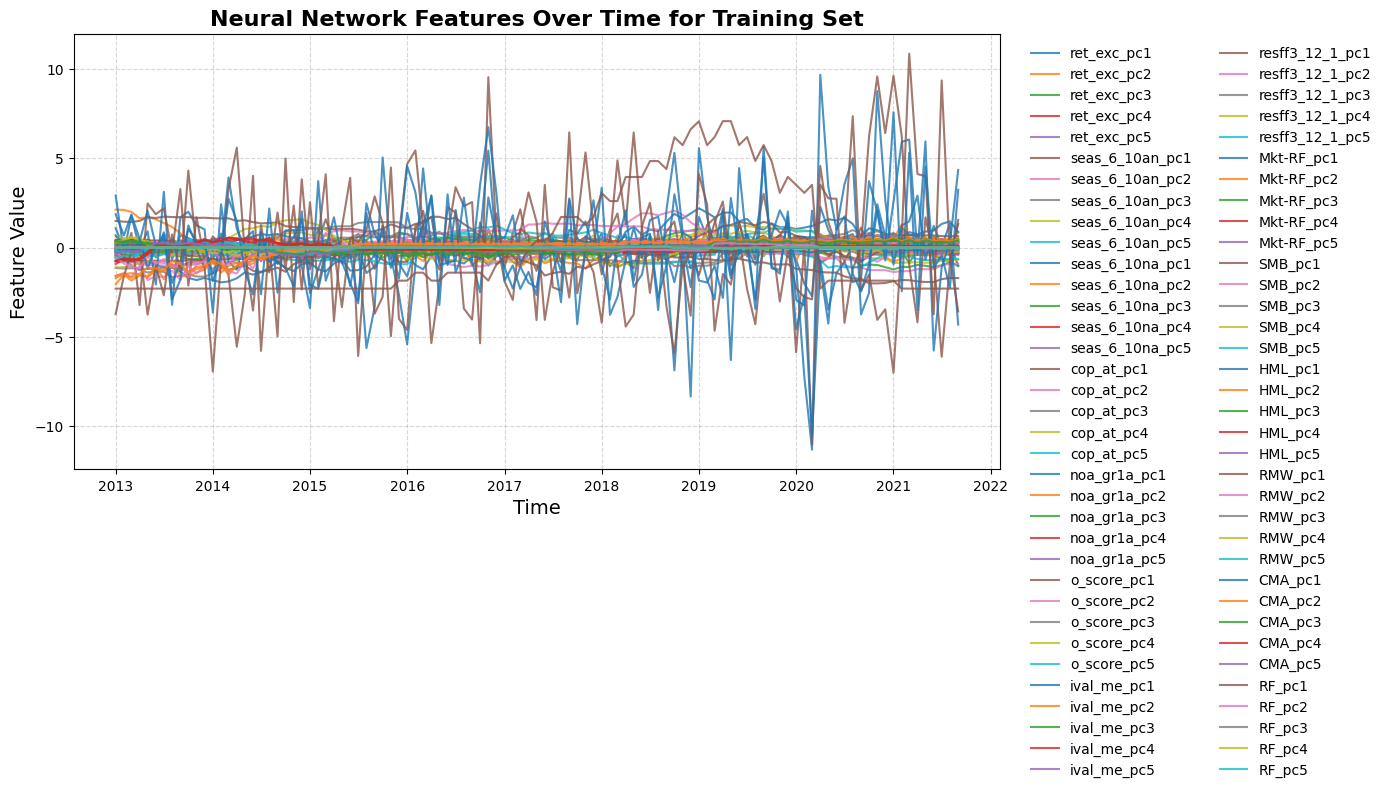

In [ ]:
import matplotlib.pyplot as plt

# Set up figure
plt.figure(figsize=(14, 7))

# Plot each feature
for column in final_df.columns:
    plt.plot(final_df.index, final_df[column], label=column, linewidth=1.5, alpha=0.8)

# Improve aesthetics
plt.title("Neural Network Features Over Time for Training Set", fontsize=16, fontweight="bold")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Feature Value", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)

# Adjust the legend to fit inside the plot neatly
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), ncol=2, fontsize=10, frameon=False)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


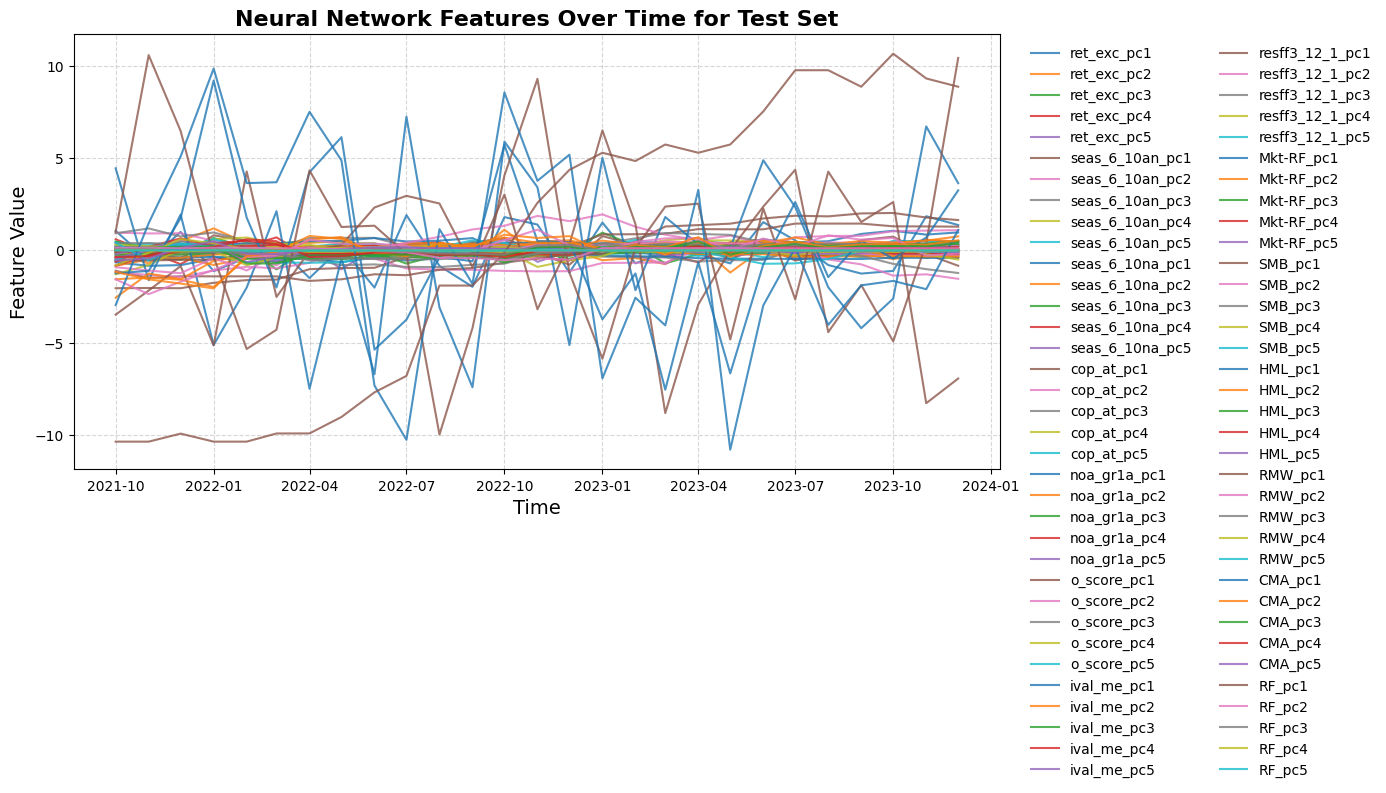

In [ ]:
import matplotlib.pyplot as plt

# Set up figure
plt.figure(figsize=(14, 7))

# Plot each feature
for column in final_df_test.columns:
    plt.plot(final_df_test.index, final_df_test[column], label=column, linewidth=1.5, alpha=0.8)

# Improve aesthetics
plt.title("Neural Network Features Over Time for Test Set", fontsize=16, fontweight="bold")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Feature Value", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)

# Adjust the legend to fit inside the plot neatly
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), ncol=2, fontsize=10, frameon=False)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
training_tensor,training_index=create_dataset_train_modified(final_df, 12, 1, 12, final_df.shape[1])

In [ ]:
test_tensor,test_index=create_dataset_train_modified(final_df_test, 12, 1, 12, final_df_test.shape[1])

In [ ]:
target_tensor,target_index=create_dataset_target(target_set, 12, 1, 12)

Original Target Shape: (92, 12, 442)


In [ ]:
training_tensor.shape

(84, 12, 70)

In [ ]:
training_tensor.shape

(84, 12, 70)

In [ ]:
target_tensor.shape

(84, 12, 442)

In [ ]:
import tensorflow as tf

class SharpeRatioLoss(tf.keras.losses.Loss):
    def __init__(self, risk_free_rate=0.0, epsilon=1e-3):
        super().__init__()
        self.risk_free_rate = risk_free_rate
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        # Optional normalization if needed (e.g., softmax for weights)
        # y_pred = tf.keras.activations.softmax(y_pred, axis=-1)

        # Ensure y_pred is 3D
        if len(y_pred.shape) == 2:
            y_pred = tf.expand_dims(y_pred, axis=-1)

        if y_pred.shape[-1] != y_true.shape[-1]:
            raise ValueError(
                f"Shape mismatch: y_pred has {y_pred.shape[-1]} assets, but y_true has {y_true.shape[-1]} assets."
            )

        # Compute portfolio returns and clip extreme values
        portfolio_returns = tf.reduce_sum(y_pred * y_true, axis=2)
        portfolio_returns = tf.clip_by_value(portfolio_returns, -1e3, 1e3)
        tf.debugging.check_numerics(portfolio_returns, message="Portfolio returns contain NaNs")

        # Mean return
        mean_return = tf.reduce_mean(portfolio_returns, axis=1)
        # Standard deviation (avoid division by zero)
        std_dev = tf.math.reduce_std(portfolio_returns, axis=1)
        std_dev_safe = tf.where(tf.less(std_dev, self.epsilon), self.epsilon, std_dev)
        tf.debugging.check_numerics(std_dev_safe, message="Standard deviation (safe) contains NaNs")

        # Compute Sharpe ratio
        sharpe_ratio = mean_return / std_dev_safe
        sharpe_ratio = tf.clip_by_value(sharpe_ratio, -1e3, 1e3)
        tf.debugging.check_numerics(sharpe_ratio, message="Sharpe ratio contains NaNs")

        loss = -tf.reduce_mean(sharpe_ratio)
        tf.debugging.check_numerics(loss, message="Loss contains NaNs")
        return loss


In [ ]:
def contains_nan(tensor):
    """Return True if the tensor contains any NaNs, else False."""
    return tf.reduce_any(tf.math.is_nan(tensor))

# Check training_tensor
if contains_nan(training_tensor):
    print("training_tensor contains NaNs.")
else:
    print("training_tensor does not contain NaNs.")

# Check target_tensor
if contains_nan(target_tensor):
    print("target_tensor contains NaNs.")
else:
    print("target_tensor does not contain NaNs.")

training_tensor does not contain NaNs.
target_tensor does not contain NaNs.


In [ ]:
if contains_nan(training_tensor):
    print("training_tensor contains NaNs.")
else:
    print("training_tensor does not contain NaNs.")

training_tensor does not contain NaNs.


In [ ]:
models = {}
learning_rate = 1e-5  # Lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

model = LSTM_Encoder(
    length=12,
    d_data=training_tensor.shape[2],
    d_model=target_tensor.shape[2],  # target_dim, e.g., 473
    target_dim=target_tensor.shape[2],
    num_layers=4,
    num_heads=4,
    dff=target_tensor.shape[2] * 4,  # e.g., 4x target_dim
    dropout_rate=0.1
)

model.compile(optimizer=optimizer, loss=SharpeRatioLoss(epsilon=1e-3))
model.fit(training_tensor, target_tensor, epochs=10, batch_size=12)
models['arch'] = model

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: -0.6222
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: -1.3350
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: -2.0462
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: -2.7226
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: -3.1103
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: -3.5790
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: -4.7167
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: -4.4858
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: -5.9085
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: -4.3732


In [ ]:
test_index

DatetimeIndex(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
import numpy as np

# Make predictions on the test set.
# This will output a tensor of shape (num_samples, seq_length, target_dim)
predictions = model.predict(test_tensor)

# Option 1: Use the predictions from the last time step.
final_predictions = predictions[:, -1, :]  # shape: (num_samples, target_dim)

# Option 2: (Alternate) Average the predictions over the sequence.
# final_predictions = np.mean(predictions, axis=1)  # shape: (num_samples, target_dim)

# Now, suppose each column corresponds to a stock.
# For each sample, we can rank the stocks by sorting the weights in descending order.
# For example, for the first sample:
sample_index = 0
stock_weights = final_predictions[sample_index]  # shape: (target_dim,)
# Get ranking indices (highest weight first)
ranking_indices = np.argsort(-stock_weights)
print("For sample", sample_index, "the ranking of stocks (by index) is:")
print(ranking_indices)

# If you want an overall ranking across the test set,
# you could average the weights over all samples.
average_weights = np.mean(final_predictions, axis=0)  # shape: (target_dim,)
overall_ranking = np.argsort(-average_weights)
print("Overall ranking of stocks (by index):")
print(overall_ranking)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
For sample 0 the ranking of stocks (by index) is:
[389 428 110  60 296 128  20  37 101 439 168 291 390 414 207 327  88 434
 336  73 330 391 230 145 114 149 175 122 410  24 144 227 379 135 287 224
 221 141 381 371 418 338  57 256 372 259 154 353 366 427 289 171 252 298
  27  76 396 432 311 292 206 387 377  84 436  77  11  49 228 271  14 307
 350 421 201 263 321 260 413 208 431 284 200  36 310 124 147 160 393  83
 151 167 378 437 293 399 161 335  71 116 376  28 384 343 306 354 185 191
  16  53 380 347 398 225  55 440 317  31 382 197  47 302 240 272 345 324
 112 363 218 358  66 196  93 270  65 402 357  68 383 251 142 309 368  48
  41 169 253  99 102 419 153 408  98 134 152   2 215 267 199  78 178 236
  17 280  23 268 205 352 304 159 276 438  94 213 103 364  54 249 283 140
 247 243  10 246 182 392 212  26 329  42  92 229 183 179 165 426 248 210
 441 359 130 148 156 238  56 234 316 158 369 265 281 337 342 164 365 261
 273 181 189 126 339 416 409 288 420  

In [ ]:
import numpy as np

# Make predictions on the test set.
# This will output a tensor of shape (num_samples, seq_length, target_dim)
predictions = model.predict(test_tensor)

# Option 1: Use the predictions from the last time step.
final_predictions = predictions[:, -1, :]  # shape: (num_samples, target_dim)

# Option 2: (Alternate) Average the predictions over the sequence.
# final_predictions = np.mean(predictions, axis=1)  # shape: (num_samples, target_dim)

# Now, suppose each column corresponds to a stock.
# For each sample, we can rank the stocks by sorting the weights in descending order.
# For example, for the first sample:
#stock_weights = final_predictions[test_index]  # shape: (target_dim,)
# Get ranking indices (highest weight first)
#ranking_indices = np.argsort(-stock_weights)
#print("For sample", test_index, "the ranking of stocks (by index) is:")
#print(ranking_indices)

# If you want an overall ranking across the test set,
# you could average the weights over all samples.
#average_weights = np.mean(final_predictions, axis=0)  # shape: (target_dim,)
#overall_ranking = np.argsort(-average_weights)
#print("Overall ranking of stocks (by index):")
#print(overall_ranking)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [ ]:
final_predictions.shape

(12, 442)

In [ ]:
predictions_df=pd.DataFrame(final_predictions,columns=tickers[:442],index=test_index[-12:])

In [ ]:
predictions_df

tickers,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,UBER,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VICI
2023-01-01,-0.188412,-0.819240,0.484933,-0.453235,-0.118470,-0.926867,-0.829751,0.016327,-0.963578,-0.166172,...,0.885296,-0.951291,0.964698,-0.653602,0.845625,0.754442,0.413965,0.978746,0.690406,0.247450
2023-02-01,-0.185722,-0.819662,0.484943,-0.452329,-0.118302,-0.926784,-0.830048,0.017166,-0.963568,-0.166654,...,0.885543,-0.951281,0.964779,-0.654326,0.845335,0.753073,0.414991,0.978695,0.690075,0.247517
2023-03-01,-0.187273,-0.819163,0.485569,-0.453550,-0.118005,-0.926987,-0.829846,0.016971,-0.963605,-0.166507,...,0.885213,-0.951236,0.964764,-0.654151,0.845426,0.753575,0.414314,0.978721,0.690818,0.248060
2023-04-01,-0.185420,-0.819185,0.483819,-0.454009,-0.117478,-0.927047,-0.829993,0.016836,-0.963567,-0.165374,...,0.885231,-0.951239,0.964786,-0.654589,0.845643,0.753470,0.414171,0.978708,0.690403,0.248748
2023-05-01,-0.186056,-0.819493,0.484612,-0.454431,-0.118459,-0.927254,-0.829816,0.017454,-0.963577,-0.167487,...,0.885208,-0.951304,0.964806,-0.654920,0.845231,0.753696,0.414276,0.978708,0.690032,0.247947
2023-06-01,-0.186535,-0.819267,0.484598,-0.453412,-0.118617,-0.926921,-0.829842,0.015389,-0.963443,-0.166332,...,0.885587,-0.951170,0.964788,-0.653897,0.844946,0.752529,0.414309,0.978745,0.690125,0.248110
2023-07-01,-0.186831,-0.818935,0.483871,-0.453513,-0.117661,-0.927145,-0.829165,0.016388,-0.963463,-0.166170,...,0.885381,-0.951154,0.964850,-0.655176,0.845424,0.753447,0.413073,0.978762,0.689345,0.248213
2023-08-01,-0.187473,-0.819591,0.484200,-0.454212,-0.117548,-0.927328,-0.829228,0.017286,-0.963519,-0.166381,...,0.885062,-0.951162,0.964919,-0.655379,0.845313,0.753152,0.414789,0.978737,0.689046,0.247610
2023-09-01,-0.186462,-0.820308,0.483501,-0.452722,-0.116730,-0.927235,-0.830255,0.017958,-0.963488,-0.168948,...,0.885269,-0.951093,0.964847,-0.654587,0.844906,0.754136,0.414615,0.978625,0.689109,0.243434
2023-10-01,-0.186744,-0.820265,0.486203,-0.453792,-0.116756,-0.927029,-0.830680,0.017965,-0.963518,-0.169896,...,0.885544,-0.950933,0.964878,-0.654881,0.844938,0.754176,0.413540,0.978632,0.689862,0.243028


In [ ]:
def create_decile_portfolios(pred_df):
    """
    Given a DataFrame of predictions with dates as the index and tickers as columns,
    this function creates decile portfolios by ranking the predictions on each date.

    It returns:
      - decile_assignments: DataFrame with the same shape as pred_df where each cell
                            contains the decile group (1 to 10) for that ticker on that date.
      - decile_means: DataFrame with dates as the index and decile numbers (1 to 10) as columns,
                      where each cell is the average predicted value for that decile group on that date.
    """
    # Create empty DataFrames to store decile assignments and decile means.
    decile_assignments = pd.DataFrame(index=pred_df.index, columns=pred_df.columns)
    decile_means = pd.DataFrame(index=pred_df.index, columns=range(1, 11))

    # Loop through each date (row) in the prediction DataFrame.
    for date in pred_df.index:
        # Get the predictions for the date; drop NaN values if any.
        row = pred_df.loc[date].dropna()

        # Check if there are enough unique values to create 10 deciles.
        if row.nunique() < 10:
            # If not, assign NaN decile for this date.
            deciles = pd.Series(np.nan, index=row.index)
        else:
            # Use pd.qcut to assign decile groups (1 to 10); lowest values get decile 1.
            deciles = pd.qcut(row, 10, labels=False) + 1

        # Fill in the decile assignments for this date.
        decile_assignments.loc[date, deciles.index] = deciles

        # Calculate the average prediction for each decile group.
        for dec in range(1, 11):
            # Select stocks in the current decile.
            group_values = row[deciles == dec]
            # Compute the mean for this decile; if no stocks, set as NaN.
            decile_means.loc[date, dec] = group_values.mean() if not group_values.empty else np.nan

    return decile_assignments, decile_means

# --- Example Usage ---
# Suppose pred_df is your DataFrame of predictions.
# For example:
# pred_df =
# tickers       A      AAPL    ABBV   ABNB   ...   ZBRA    ZTS
# 2017-12-01 0.391412 -0.955903 0.377957 -0.633543 ...  -0.819471 0.179298
# 2018-01-01 0.391199 -0.955949 0.377955 -0.633269 ...  -0.819547 0.179085
# ...

# Create decile portfolios:

In [ ]:
def get_decile_stock_lists(pred_df):
    """
    For each date (row) in the predictions DataFrame, rank the stocks and
    split them into deciles (1 to 10). Returns a dictionary where each key is a date
    and its value is a dictionary mapping decile numbers (1-10) to a list of stock tickers
    that fall into that decile.

    Parameters:
    -----------
    pred_df : pd.DataFrame
        DataFrame with dates as index and tickers as columns, containing predictions.

    Returns:
    --------
    dict
        Dictionary of the form:
        { date1: {1: [tickerA, tickerB, ...],
                   2: [tickerC, tickerD, ...],
                   ...,
                   10: [...] },
          date2: { ... },
          ... }
    """
    decile_dict = {}

    for date in pred_df.index:
        # Get predictions for this date as a Series (ticker names are the index)
        row = pred_df.loc[date].dropna()

        # Check if there are enough unique values to create deciles
        if row.nunique() < 10:
            # Not enough unique values: assign empty lists for each decile.
            decile_assignments = {d: [] for d in range(1, 11)}
        else:
            # Use pd.qcut to divide the ranked values into 10 equal groups
            # labels=False returns integers 0-9; add 1 to make deciles 1-10.
            decile_labels = pd.qcut(row, 10, labels=False) + 1

            # Create a dictionary mapping decile number to the list of tickers in that decile.
            decile_assignments = {}
            for d in range(1, 11):
                tickers_in_decile = row.index[decile_labels == d].tolist()
                decile_assignments[d] = tickers_in_decile

        decile_dict[date] = decile_assignments

    return decile_dict

In [ ]:
example_date = predictions_df.index[-1]
print(f"Decile groups for {example_date}:")
for decile, tickers in get_decile_stock_lists(predictions_df)[example_date].items():
    print(f"  Decile {decile}: {tickers}")

Decile groups for 2023-12-01 00:00:00:
  Decile 1: ['ACGL', 'ADI', 'AKAM', 'AOS', 'AXP', 'BWA', 'C', 'CAG', 'CB', 'CBOE', 'CHRW', 'CHTR', 'CLX', 'CRM', 'CRWD', 'CSX', 'DE', 'DHI', 'DIS', 'DRI', 'DVA', 'FCX', 'FDX', 'IBM', 'IEX', 'ITW', 'LHX', 'MAR', 'MAS', 'MKC', 'MNST', 'MSFT', 'NDSN', 'NUE', 'OMC', 'PAYC', 'PFE', 'ROK', 'ROL', 'SLB', 'STLD', 'STT', 'SWKS', 'T', 'UHS']
  Decile 2: ['AAPL', 'ACN', 'AJG', 'AMP', 'APA', 'ATO', 'AWK', 'AXON', 'BLK', 'BR', 'CF', 'CNC', 'CPB', 'CVX', 'DLTR', 'EPAM', 'GD', 'GEHC', 'GIS', 'HBAN', 'HLT', 'HON', 'HWM', 'INTC', 'IRM', 'L', 'LLY', 'LOW', 'LYB', 'MCK', 'MDT', 'MPWR', 'NKE', 'NOC', 'NSC', 'PAYX', 'PGR', 'RMD', 'SNA', 'SYF', 'TAP', 'TDY', 'TFX', 'TXT']
  Decile 3: ['ALL', 'APO', 'AZO', 'BRK.B', 'CE', 'CEG', 'CL', 'CNP', 'CPRT', 'CZR', 'D', 'DAY', 'DOV', 'DTE', 'EBAY', 'EQT', 'EW', 'EXPE', 'FICO', 'FOX', 'GLW', 'GNRC', 'GOOG', 'HCA', 'HRL', 'IDXX', 'JPM', 'KKR', 'MET', 'MPC', 'MRK', 'NVDA', 'NWSA', 'OKE', 'ON', 'PEG', 'PG', 'RF', 'SJM', 'TDG', 'TPL',

In [ ]:
def normalize_df(df):
    """
    Normalizes every numeric column in the DataFrame to the range [0, 1].

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame.

    Returns:
    --------
    pd.DataFrame
        A new DataFrame with each numeric column normalized to [0, 1].
    """
    df_norm = df.copy()

    for col in df_norm.columns:
        # Process only numeric columns
        if pd.api.types.is_numeric_dtype(df_norm[col]):
            col_min = df_norm[col].min()
            col_max = df_norm[col].max()
            # Avoid division by zero for constant columns
            if col_max - col_min == 0:
                df_norm[col] = 0.0
            else:
                df_norm[col] = (df_norm[col] - col_min) / (col_max - col_min)

    return df_norm

In [ ]:
import pandas as pd
import numpy as np

def rank_predictions_into_deciles(predictions_df):
    """
    For each date (row) in predictions_df, rank the stocks by their predicted value
    and split them into deciles (1 to 10). Returns a dictionary where:
      - Keys are dates.
      - Values are dictionaries mapping decile number (1 to 10) to a list of tickers
        that fall in that decile.

    Parameters:
    -----------
    predictions_df : pd.DataFrame
        DataFrame with dates as index and ticker symbols as columns.

    Returns:
    --------
    decile_dict : dict
        Dictionary mapping each date to decile portfolios.
    """
    decile_dict = {}

    for date in predictions_df.index:
        # Get the predictions for the current date.
        row = predictions_df.loc[date].dropna()

        # If there are fewer than 10 unique values, we cannot form deciles.
        if row.nunique() < 10:
            decile_assignments = {d: [] for d in range(1, 11)}
        else:
            # Use pd.qcut to split the values into 10 equal groups.
            # qcut returns labels 0 to 9; we add 1 so that deciles range from 1 to 10.
            decile_labels = pd.qcut(row, 10, labels=False) + 1

            # Build a dictionary mapping decile number to list of tickers.
            decile_assignments = {}
            for dec in range(1, 11):
                tickers_in_decile = row.index[decile_labels == dec].tolist()
                # Optionally, you can sort the tickers by their prediction value:
                tickers_in_decile = sorted(tickers_in_decile, key=lambda t: row[t])
                decile_assignments[dec] = tickers_in_decile

        decile_dict[date] = decile_assignments

    return decile_dict

# --- Example Usage ---
# Assume predictions_df is your DataFrame of LSTM encoder predictions
# with dates as the index and ticker symbols as the columns.
# For example:
#            AAPL      MSFT     GOOG   ...  ZTS
# 2023-01-01  0.12     0.05     -0.03  ...  0.09
# 2023-02-01  0.08     0.03      0.01  ...  0.10
# ...

decile_portfolios = rank_predictions_into_deciles(predictions_df)

# To print the decile assignments for a particular date:
example_date = predictions_df.index[0]
print(f"Decile portfolios for {example_date}:")
for decile, tickers in decile_portfolios[example_date].items():
    print(f"  Decile {decile}: {tickers}")


Decile portfolios for 2023-01-01 00:00:00:
  Decile 1: ['FDX', 'ITW', 'STLD', 'AKAM', 'PFE', 'MKC', 'NUE', 'CLX', 'CB', 'OMC', 'MAR', 'ADI', 'PAYC', 'MSFT', 'T', 'CRM', 'UHS', 'DE', 'NDSN', 'CHTR', 'STT', 'C', 'IEX', 'BWA', 'ROK', 'MAS', 'CAG', 'DIS', 'MNST', 'ACGL', 'AXP', 'DVA', 'FCX', 'SLB', 'DRI', 'CSX', 'CRWD', 'LHX', 'CHRW', 'CBOE', 'SWKS', 'IBM', 'ROL', 'AOS', 'DHI']
  Decile 2: ['LOW', 'AMP', 'SYF', 'CF', 'LLY', 'IRM', 'MPWR', 'ACN', 'PAYX', 'BR', 'CVX', 'AXON', 'AWK', 'NOC', 'AAPL', 'DLTR', 'ATO', 'LYB', 'CNC', 'TDY', 'SNA', 'HON', 'BLK', 'APA', 'NKE', 'HWM', 'MDT', 'TAP', 'TFX', 'CPB', 'AJG', 'RMD', 'GEHC', 'MCK', 'EPAM', 'HBAN', 'GD', 'INTC', 'NSC', 'HLT', 'PGR', 'L', 'GIS', 'TXT']
  Decile 3: ['MET', 'MPC', 'AZO', 'D', 'BRK.B', 'OKE', 'JPM', 'DOV', 'TRV', 'UNH', 'HRL', 'RF', 'PEG', 'GLW', 'GOOG', 'CEG', 'ON', 'NVDA', 'TDG', 'CZR', 'HCA', 'EQT', 'EW', 'GNRC', 'CNP', 'SJM', 'MRK', 'FICO', 'DAY', 'CL', 'KKR', 'TYL', 'IDXX', 'PG', 'DTE', 'CE', 'CPRT', 'TPL', 'FOX', 'APO', 'EXPE

In [ ]:
import pandas as pd
import numpy as np

def compute_DL_factor(predictions_df):
    """
    Compute the DL_Momentum_Factor from LSTM encoder predictions.

    For each date, stocks are ranked into deciles. The factor is defined as:

        DL_Momentum_Factor = (Average prediction of decile 10) - (Average prediction of decile 1)

    Parameters:
    -----------
    predictions_df : pd.DataFrame
        DataFrame with dates as index and ticker symbols as columns containing predictions.

    Returns:
    --------
    pd.DataFrame
        A DataFrame with a single column 'DL_Momentum_Factor' and dates as the index.
    """
    factor_values = {}

    for date in predictions_df.index:
        # Get the predictions for the current date
        row = predictions_df.loc[date].dropna()

        # Check if there are at least 10 unique values to form deciles
        if row.nunique() < 10:
            factor_values[date] = np.nan
        else:
            # Rank the predictions into deciles (1 = bottom, 10 = top)
            decile_labels = pd.qcut(row, 10, labels=False) + 1  # Labels: 1 to 10

            # Compute mean predictions for decile 10 and decile 1
            top_mean = row[decile_labels == 10].mean()
            bottom_mean = row[decile_labels == 1].mean()

            # Compute the DL_Momentum_Factor as the difference
            factor_values[date] = top_mean - bottom_mean

    # Create a DataFrame from the factor values
    factor_df = pd.DataFrame.from_dict(factor_values, orient='index', columns=['DL_Momentum_Factor'])
    factor_df.index.name = 'date'

    return factor_df

# --- Example Usage ---
# Suppose predictions_df is your DataFrame of LSTM encoder predictions:
# predictions_df =
#              AAPL    MSFT   GOOG   ...  ZTS
# 2023-01-01   0.12    0.05   -0.03  ...  0.09
# 2023-02-01   0.08    0.03    0.01  ...  0.10
# ...
#
# Then compute the DL_Momentum_Factor as follows:


In [ ]:
DL_Factor=compute_DL_momentum_factor(predictions_df)

In [ ]:
DL_Factor_Norm=normalize_df(DL_Factor)

In [ ]:
market= ff_5_monthly[ff_5_monthly.columns[0]]
# Use the first deep learning factor column.
dl_factor = DL_Factor_Norm
# Construct predictor DataFrame with constant.
X = pd.concat([market, dl_factor], axis=1)
X.columns = ['Mkt-RF', 'DL_Factor']
X.dropna(inplace=True)
#X = sm.add_constant(X).dropna()

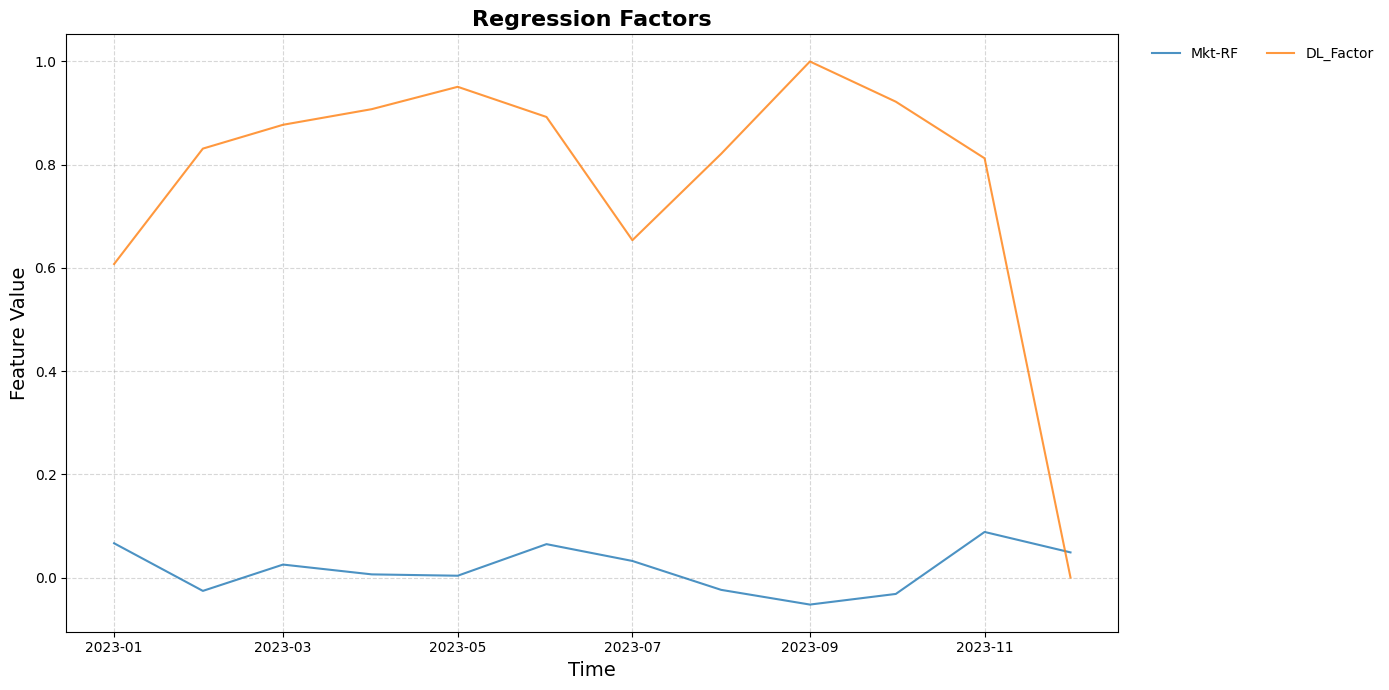

In [ ]:
import matplotlib.pyplot as plt

# Set up figure
plt.figure(figsize=(14, 7))

# Plot each feature
for column in X.columns:
    plt.plot(X.index, X[column], label=column, linewidth=1.5, alpha=0.8)

# Improve aesthetics
plt.title('Regression Factors', fontsize=16, fontweight="bold")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Feature Value", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)

# Adjust the legend to fit inside the plot neatly
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1), ncol=2, fontsize=10, frameon=False)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def run_regressions_with_factors(target_set, ff_5_monthly, normalized_dl_factors):
    """
    Runs a regression for each stock (column in target_set) using the market factor and
    normalized deep learning factors as predictors. Returns a DataFrame summarizing the results.

    Parameters:
      target_set: pd.DataFrame
          DataFrame of stock returns (index: dates, columns: stocks).
      ff_5_monthly: pd.DataFrame
          DataFrame with dates as index and a column 'Mkt-RF' for the market factor.
      normalized_dl_factors: pd.DataFrame
          DataFrame with dates as index and columns for the deep learning factors.

    Returns:
      results_df: pd.DataFrame
          A DataFrame with one row per stock, containing the estimated coefficients,
          their p-values, and the R-squared.
    """
    # Align the indices: only keep dates common to all three DataFrames.
    common_index = target_set.index.intersection(ff_5_monthly.index).intersection(normalized_dl_factors.index)
    y_data = target_set.loc[common_index]
    market = ff_5_monthly.loc[common_index, 'Mkt-RF']
    dl_factors = normalized_dl_factors.loc[common_index]

    # Combine predictors into one DataFrame.
    # First column is the market factor, then the deep learning factors.
    X = pd.concat([market, dl_factors], axis=1)
    # Add constant term.
    X = sm.add_constant(X)

    results_list = []

    for ticker in y_data.columns:
        y = y_data[ticker]
        # Run the regression. Use missing='drop' to handle any missing data.
        model = sm.OLS(y, X).fit()
        # Build a dictionary to store results.
        result_dict = {
            'Ticker': ticker,
            'Alpha': model.params.get('const', np.nan),
            #'Alpha_pval': model.pvalues.get('const', np.nan),
            'Market_Coeff': model.params.get('Mkt-RF', np.nan),
            'Market_pval': model.pvalues.get('Mkt-RF', np.nan),
            'R2': model.rsquared
        }
        # For each deep learning factor, store the coefficient and p-value.
        for factor in dl_factors.columns:
            result_dict[factor] = model.params.get(factor, np.nan)
            result_dict[factor + '_pval'] = model.pvalues.get(factor, np.nan)

        results_list.append(result_dict)

    results_df = pd.DataFrame(results_list).set_index('Ticker')
    return results_df

# --- Example Usage ---
# Assume that target_set, ff_5_monthly, and normalized_dl_factors are pre-loaded DataFrames.
# For instance:
# target_set: shape (dates, 473)
# ff_5_monthly: must have a column 'Mkt-RF'
# normalized_dl_factors: shape (dates, n_factors)

#results_df = run_regressions_with_factors(target_set, ff_5_monthly, DL_Factor_Norm)
#print("Regression Results (first few rows):")
#print(results_df.head())


In [ ]:
def run_regressions_two_factors(target_set, ff_5_monthly, normalized_dl_factors):
    """
    For each stock in target_set, regress its returns on:
      - A constant,
      - The market factor (ff_5_monthly['Mkt-RF']),
      - A deep learning factor (the first column of normalized_dl_factors).

    Only dates common to all three DataFrames are used.

    Parameters:
      target_set: pd.DataFrame
          DataFrame with dates as index and stock return series as columns.
      ff_5_monthly: pd.DataFrame
          DataFrame with dates as index and a column 'Mkt-RF' for the market factor.
      normalized_dl_factors: pd.DataFrame
          DataFrame with dates as index and one or more deep learning factor columns
          (we will use the first column as our predictor).

    Returns:
      results_df: pd.DataFrame
          A DataFrame with one row per stock that includes the estimated coefficients,
          their p-values, and the R-squared.
    """
    # Align the indices across the three DataFrames.
    common_index = target_set.index.intersection(ff_5_monthly.index).intersection(normalized_dl_factors.index)
    print(common_index)
    y_data = target_set.loc[common_index]
    market = ff_5_monthly.loc[common_index, 'Mkt-RF']
    # Use the first deep learning factor column.
    dl_factor = normalized_dl_factors

    # Construct predictor DataFrame with constant.
    X = pd.concat([market, dl_factor], axis=1)
    X.columns = ['Mkt-RF', 'DL_Factor']
    X = sm.add_constant(X)

    results_list = []

    for ticker in y_data.columns:
        y = y_data[ticker]
        model = sm.OLS(y, X, missing='drop').fit()
        results_list.append({
            'Ticker': ticker,
            'Alpha': model.params.get('const', np.nan),
            'Alpha_pval': model.pvalues.get('const', np.nan),
            'Market_Coeff': model.params.get('Mkt-RF', np.nan),
            'Market_pval': model.pvalues.get('Mkt-RF', np.nan),
            'DL_Coeff': model.params.get('DL_Factor', np.nan),
            'DL_pval': model.pvalues.get('DL_Factor', np.nan),
            'R2': model.rsquared
        })

    results_df = pd.DataFrame(results_list).set_index('Ticker')
    return results_df


In [ ]:
target_set_test

,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,...,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc,ret_exc
date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,-0.108799,0.094858,0.168379,0.170593,0.029829,0.014224,0.057062,0.043447,0.039836,0.029504,...,0.112948,0.050051,0.066619,0.219799,0.180092,0.055833,0.068985,-0.004402,-0.011012,0.000000
2021-11-01,0.021820,-0.024251,0.219799,-0.041303,-0.070486,-0.089256,-0.097537,-0.034042,-0.123649,0.014862,...,-0.055650,-0.118625,-0.068298,0.079263,-0.096132,-0.070493,-0.081808,-0.031040,-0.049171,0.000000
2021-12-01,0.085098,0.118960,-0.091435,0.063668,0.030936,0.022879,-0.003288,0.097650,0.074129,0.078433,...,0.011748,0.051930,0.051535,-0.160378,0.098364,-0.009893,0.135331,0.085583,0.058466,0.074019
2022-01-01,-0.001886,-0.091063,-0.160378,-0.072811,-0.019372,-0.055607,0.219799,0.016029,0.101729,0.075825,...,0.137590,0.002419,0.121225,-0.160378,-0.160378,-0.124294,-0.066121,-0.053698,0.048747,-0.073360
2022-02-01,0.017498,-0.053692,0.079534,-0.160378,-0.067272,-0.053195,0.094999,0.011366,0.081832,-0.021200,...,0.106438,0.098156,0.093352,0.186702,-0.160378,-0.150190,-0.044334,-0.039587,0.005141,-0.066923
2022-03-01,0.102580,-0.018797,-0.113567,0.064392,0.025395,-0.035451,0.062823,0.100547,-0.038818,0.053959,...,0.154445,-0.024326,0.097924,0.210378,0.219799,-0.041544,-0.055094,-0.102684,0.069054,-0.037870
2022-04-01,-0.077502,-0.037127,-0.160378,-0.063420,-0.005536,-0.149947,-0.037126,-0.006652,-0.062978,-0.110458,...,-0.022695,0.066650,0.020548,-0.160378,-0.106642,-0.055866,-0.092694,-0.020757,0.031183,0.040590
2022-05-01,0.090283,0.034583,0.190759,0.051344,0.005326,-0.034464,0.193736,0.037025,-0.034020,0.064113,...,-0.019242,-0.005478,0.172854,0.153287,0.219799,0.050004,-0.002716,-0.055357,0.077218,-0.022979
2022-06-01,-0.058906,-0.075571,-0.160378,-0.017060,-0.102881,-0.149644,-0.136709,-0.060255,-0.160378,-0.087078,...,-0.160378,0.034404,-0.160378,0.048039,-0.129776,-0.072614,-0.111987,-0.160378,-0.160378,-0.120048


In [ ]:
tickers=stock_returns['tickers'].unique()

In [ ]:
ff_5_monthly.columns[0]

'Mkt-RF'

In [ ]:
len(tickers)

473

In [ ]:
#ommon_index = target_set.index.intersection(ff_5_monthly.index).intersection(DL_Factor_Norm.index)
y_data = target_set_test
y_data.columns=tickers[:442]
market= ff_5_monthly[ff_5_monthly.columns[0]]
# Use the first deep learning factor column.
dl_factor = DL_Factor_Norm
# Construct predictor DataFrame with constant.
X = pd.concat([market, dl_factor], axis=1)
X.columns = ['Mkt-RF', 'DL_Factor']
X = sm.add_constant(X).dropna()

In [ ]:
y_data

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,UBER,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VICI
date,,,,,,,,,,,,,,,,,,,,,
2021-10-01,-0.108799,0.094858,0.168379,0.170593,0.029829,0.014224,0.057062,0.043447,0.039836,0.029504,...,0.112948,0.050051,0.066619,0.219799,0.180092,0.055833,0.068985,-0.004402,-0.011012,0.000000
2021-11-01,0.021820,-0.024251,0.219799,-0.041303,-0.070486,-0.089256,-0.097537,-0.034042,-0.123649,0.014862,...,-0.055650,-0.118625,-0.068298,0.079263,-0.096132,-0.070493,-0.081808,-0.031040,-0.049171,0.000000
2021-12-01,0.085098,0.118960,-0.091435,0.063668,0.030936,0.022879,-0.003288,0.097650,0.074129,0.078433,...,0.011748,0.051930,0.051535,-0.160378,0.098364,-0.009893,0.135331,0.085583,0.058466,0.074019
2022-01-01,-0.001886,-0.091063,-0.160378,-0.072811,-0.019372,-0.055607,0.219799,0.016029,0.101729,0.075825,...,0.137590,0.002419,0.121225,-0.160378,-0.160378,-0.124294,-0.066121,-0.053698,0.048747,-0.073360
2022-02-01,0.017498,-0.053692,0.079534,-0.160378,-0.067272,-0.053195,0.094999,0.011366,0.081832,-0.021200,...,0.106438,0.098156,0.093352,0.186702,-0.160378,-0.150190,-0.044334,-0.039587,0.005141,-0.066923
2022-03-01,0.102580,-0.018797,-0.113567,0.064392,0.025395,-0.035451,0.062823,0.100547,-0.038818,0.053959,...,0.154445,-0.024326,0.097924,0.210378,0.219799,-0.041544,-0.055094,-0.102684,0.069054,-0.037870
2022-04-01,-0.077502,-0.037127,-0.160378,-0.063420,-0.005536,-0.149947,-0.037126,-0.006652,-0.062978,-0.110458,...,-0.022695,0.066650,0.020548,-0.160378,-0.106642,-0.055866,-0.092694,-0.020757,0.031183,0.040590
2022-05-01,0.090283,0.034583,0.190759,0.051344,0.005326,-0.034464,0.193736,0.037025,-0.034020,0.064113,...,-0.019242,-0.005478,0.172854,0.153287,0.219799,0.050004,-0.002716,-0.055357,0.077218,-0.022979
2022-06-01,-0.058906,-0.075571,-0.160378,-0.017060,-0.102881,-0.149644,-0.136709,-0.060255,-0.160378,-0.087078,...,-0.160378,0.034404,-0.160378,0.048039,-0.129776,-0.072614,-0.111987,-0.160378,-0.160378,-0.120048


In [ ]:
X

,const,Mkt-RF,DL_Factor
date,,,
2023-01-01,1.0,0.0664,0.607504
2023-02-01,1.0,-0.0259,0.831169
2023-03-01,1.0,0.0251,0.877345
2023-04-01,1.0,0.0061,0.907648
2023-05-01,1.0,0.0035,0.950938
2023-06-01,1.0,0.0647,0.892496
2023-07-01,1.0,0.0321,0.653680
2023-08-01,1.0,-0.0239,0.821068
2023-09-01,1.0,-0.0524,1.000000


In [ ]:
X['DL_Factor'].shape

(12,)

In [ ]:
ic_values = []
t_values = []
rank_ic_values = []
returns_df=y_data.loc[X.index,:]
#returns_df = returns_data.dropna()
dl_factor = np.array(dl_factor).flatten()


for stock in returns_df.columns:
    y = returns_df[stock].values.flatten()
    X=X #Just for remebrance that it was already computed
    model = sm.OLS(y, X).fit()

    ic_values.append(model.params['DL_Factor'])  # Store IC values
    t_values.append(model.tvalues['DL_Factor'])  # Store t-values

    # RankIC calculation using Spearman's rank correlation to handle non-linearity
    if len(dl_factor) == len(y):
        rank_ic_values.append(pd.Series(dl_factor).corr(y, method='spearman'))
    else:
        rank_ic_values.append(np.nan)

# Convert lists to arrays for calculations
ic_values = np.array(ic_values)
t_values = np.array(t_values)
rank_ic_values = np.array(rank_ic_values)

# Compute required statistics
ic_mean = np.mean(ic_values)
ic_std = np.std(ic_values)
icir = ic_mean / ic_std if ic_std != 0 else np.nan
proportion_ic_gt_zero = np.mean(ic_values > 0) * 100
proportion_ic_abs_gt_002 = np.mean(np.abs(ic_values) > 0.02) * 100

rank_ic_mean = np.mean(rank_ic_values)
rank_ic_std = np.std(rank_ic_values)
rank_icir = rank_ic_mean / rank_ic_std if rank_ic_std != 0 else np.nan
proportion_rank_ic_gt_zero = np.mean(rank_ic_values > 0) * 100
proportion_rank_ic_abs_gt_002 = np.mean(np.abs(rank_ic_values) > 0.02) * 100

t_value_mean = np.mean(np.abs(t_values))
proportion_t_value_gt_1_96 = np.mean(np.abs(t_values) > 1.96) * 100

# Creating the results DataFrame
dl_factor_statistics = pd.DataFrame({
    "Metric": [
        "Mean IC", "IC std", "ICIR",
        "Proportion that IC > 0", "Proportion that |IC| > 0.02",
        "Mean RankIC", "RankIC std", "RankICIR",
        "Proportion that RankIC > 0", "Proportion that |RankIC| > 0.02",
        "|t-value| mean", "Proportion that |t-value| > 1.96"
    ],
    "Value": [
        ic_mean, ic_std, icir,
        proportion_ic_gt_zero, proportion_ic_abs_gt_002,
        rank_ic_mean, rank_ic_std, rank_icir,
        proportion_rank_ic_gt_zero, proportion_rank_ic_abs_gt_002,
        t_value_mean, proportion_t_value_gt_1_96
    ]
})

# Display results
print(dl_factor_statistics)

TypeError: unsupported type: <class 'numpy.ndarray'>

In [ ]:
# Adjusting RankIC calculation to ensure proper type compatibility

# Ensure the returns DataFrame matches the independent variables index
returns_df = returns_df.loc[X.index, :]

# Convert dl_factor to a Pandas Series to match types
dl_factor_series = pd.Series(dl_factor.flatten(), index=X.index)

# Initialize storage for IC, RankIC, and t-values
ic_values = []
t_values = []
rank_ic_values = []

for stock in returns_df.columns:
    y = returns_df[stock]  # Ensure y is a Pandas Series with matching index
    model = sm.OLS(y, X).fit()  # Perform regression

    ic_values.append(model.params['DL_Factor'])  # Store IC values
    t_values.append(model.tvalues['DL_Factor'])  # Store t-values

    # Compute RankIC ensuring alignment of indices
    y_series = pd.Series(y, index=X.index)
    rank_ic_values.append(dl_factor_series.corr(y_series, method='spearman'))

# Convert lists to arrays for calculations
ic_values = np.array(ic_values)
t_values = np.array(t_values)
rank_ic_values = np.array(rank_ic_values)

# Compute required statistics
ic_mean = np.mean(ic_values)
ic_std = np.std(ic_values)
icir = ic_mean / ic_std if ic_std != 0 else np.nan
proportion_ic_gt_zero = np.mean(ic_values > 0) * 100
proportion_ic_abs_gt_002 = np.mean(np.abs(ic_values) > 0.02) * 100

rank_ic_mean = np.nanmean(rank_ic_values)
rank_ic_std = np.nanstd(rank_ic_values)
rank_icir = rank_ic_mean / rank_ic_std if rank_ic_std != 0 else np.nan
proportion_rank_ic_gt_zero = np.mean(rank_ic_values > 0) * 100
proportion_rank_ic_abs_gt_002 = np.mean(np.abs(rank_ic_values) > 0.02) * 100

t_value_mean = np.mean(np.abs(t_values))
proportion_t_value_gt_1_96 = np.mean(np.abs(t_values) > 1.96) * 100

# Creating the results DataFrame
dl_factor_statistics = pd.DataFrame({
    "Metric": [
        "Mean IC", "IC std", "ICIR",
        "Proportion that IC > 0", "Proportion that |IC| > 0.02",
        "Mean RankIC", "RankIC std", "RankICIR",
        "Proportion that RankIC > 0", "Proportion that |RankIC| > 0.02",
        "|t-value| mean", "Proportion that |t-value| > 1.96"
    ],
    "Value": [
        ic_mean, ic_std, icir,
        proportion_ic_gt_zero, proportion_ic_abs_gt_002,
        rank_ic_mean, rank_ic_std, rank_icir,
        proportion_rank_ic_gt_zero, proportion_rank_ic_abs_gt_002,
        t_value_mean, proportion_t_value_gt_1_96
    ]
})

# Display the results DataFrame

In [ ]:
dl_factor_statistics = pd.DataFrame({
    "Metric": [
        "Mean IC", "IC std", "ICIR",
        "Proportion that IC > 0 (%)", "Proportion that |IC| > 0.02 (%)",
        "Mean RankIC", "RankIC std", "RankICIR",
        "Proportion that RankIC > 0 (%)", "Proportion that |RankIC| > 0.02 (%)",
        "|t-value| mean", "Proportion that |t-value| > 1.96 (%)"
    ],
    "Value": [
        ic_mean, ic_std, icir,
        f"{proportion_ic_gt_zero:.2f}%", f"{proportion_ic_abs_gt_002:.2f}%",
        rank_ic_mean, rank_ic_std, rank_icir,
        f"{proportion_rank_ic_gt_zero:.2f}%", f"{proportion_rank_ic_abs_gt_002:.2f}%",
        t_value_mean, f"{proportion_t_value_gt_1_96:.2f}%"
    ]
})

In [ ]:
dl_factor_statistics

,Metric,Value
0,Mean IC,-0.022483
1,IC std,0.081215
2,ICIR,-0.276835
3,Proportion that IC > 0 (%),41.86%
4,Proportion that |IC| > 0.02 (%),78.73%
5,Mean RankIC,-0.381377
6,RankIC std,0.264511
7,RankICIR,-1.441818
8,Proportion that RankIC > 0 (%),8.60%
9,Proportion that |RankIC| > 0.02 (%),97.74%


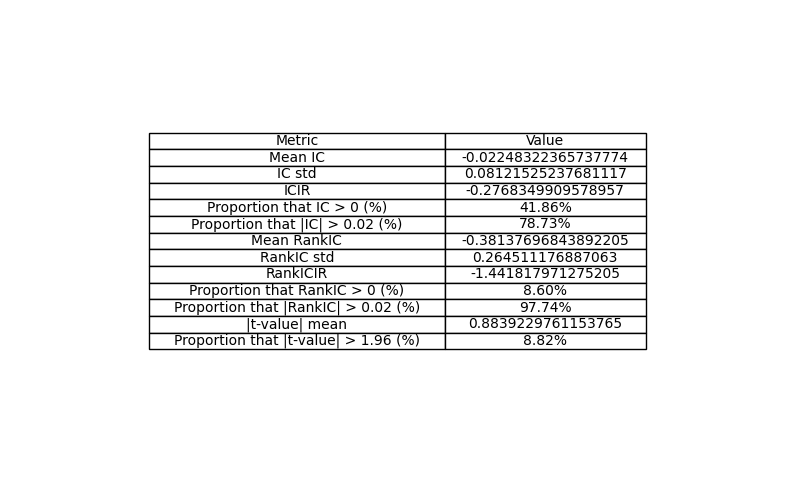

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table plot
table = ax.table(cellText=dl_factor_statistics.values,
                 colLabels=dl_factor_statistics.columns,
                 cellLoc='center', loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1])

# Save the table as an image
plt.savefig("deep_learning_factor_statistics_table.png", bbox_inches='tight', dpi=300)

# Show the table
plt.show()

In [ ]:
results_list = []
for ticker in y_data.columns:
  try:
    y = y_data.loc[X.index,ticker]
    model = sm.OLS(y, X, missing='drop').fit()
    results_list.append({
        'Ticker': ticker,
        'Alpha': model.params.get('const', np.nan),
        'Alpha_pval': model.pvalues.get('const', np.nan),
        'Market_Coeff': model.params.get('Mkt-RF', np.nan),
        'Market_pval': model.pvalues.get('Mkt-RF', np.nan),
        'DL_Coeff': model.params.get('DL_Factor', np.nan),
        'DL_pval': model.pvalues.get('DL_Factor', np.nan),
        'R2': model.rsquared
        })
  except Exception as e:
      print(f"Skipping ticker {ticker} due to error: {e}")
      continue

  results_df = pd.DataFrame(results_list).set_index('Ticker')


In [ ]:
results_df

,Alpha,Alpha_pval,Market_Coeff,Market_pval,DL_Coeff,DL_pval,R2
Ticker,,,,,,,
A,-0.076038,0.073401,0.583928,0.054116,0.080173,0.101664,0.393769
AAPL,-0.022047,0.683789,1.133102,0.013206,0.003770,0.952393,0.558271
ABBV,0.120346,0.361593,1.291944,0.176152,-0.099624,0.514295,0.319914
ABNB,-0.022757,0.715865,0.684035,0.142596,0.001432,0.984351,0.257454
ABT,-0.012004,0.824042,0.679212,0.098438,-0.002671,0.966275,0.320019
...,...,...,...,...,...,...,...
UPS,-0.013029,0.845750,1.174978,0.030230,-0.005315,0.945964,0.478459
URI,0.122413,0.107140,1.182195,0.036219,-0.162522,0.073260,0.661627
USB,0.038899,0.693779,1.370611,0.071938,-0.060733,0.601181,0.422524
